In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re

import time
import torch
import torch.nn

import random
import pickle


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
4
Tesla V100-SXM2-32GB


In [3]:
import torch.backends.cudnn as cudnn
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
else:
    device = torch.device("cpu")
    cudnn.benchmark=False

print(device)
print(torch.cuda.get_device_name(0))

cuda:0
Tesla V100-SXM2-32GB


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Load model

In [5]:
### remove nan values
def remove_nan(y):
    nan_idx = np.where(pd.isna(y))[0]
    return y.drop(y.index[nan_idx], axis=0)

In [6]:
### Discretize the continuous variables into 2 or 3 categories - low, (moderate), high
def if_discretize(y_nonan):
    if y_nonan.dtype.name == 'object':
        y_disc = y_nonan
    elif len(np.unique(y_nonan)) <= 6:
        y_disc = y_nonan
    elif np.quantile(y_nonan, 1/2)==np.min(y_nonan):
        y_disc = pd.Series(np.where(y_nonan==np.min(y_nonan), 'Min', 'Not Min'), index=y_nonan.index)
    elif np.quantile(y_nonan, 1/2)==np.max(y_nonan):
        y_disc = pd.Series(np.where(y_nonan==np.max(y_nonan), 'Not Max', 'Max'), index=y_nonan.index)
    elif np.quantile(y_nonan, 1/3)==np.min(y_nonan) or np.quantile(y_nonan, 2/3)==np.max(y_nonan):
        y_disc = pd.qcut(y_nonan, 2, labels=['Low', 'High'])
    else:
        y_disc = pd.qcut(y_nonan, 3, labels=['Low', 'Moderate', 'High'])
    
    ### remove categories with less than 5 instances (8/2 training/testing split)
    u, c = np.unique(y_disc, return_counts=True)
    idx = np.where(np.isin(y_disc, u[c<5]))
    return y_disc.drop(index=y_disc.index[idx])

In [7]:
def balanced_over_sampling(X, y, random_seed=123):
    np.random.seed(random_seed)
    unique_value, unique_value_counts = np.unique(y, return_counts=True)
    train_class_max = np.max(unique_value_counts)
    train_samples_idx = []
    for i, y_unique in enumerate(unique_value):
        train_one_class_idx = np.where(y==y_unique)[0]
        train_one_sample_idx = np.concatenate([train_one_class_idx,
                                               np.random.choice(train_one_class_idx, 
                                                                size=train_class_max-len(train_one_class_idx), replace=True)])
        train_samples_idx.append(train_one_sample_idx)
    train_balanced_idx = np.random.permutation(np.concatenate(train_samples_idx))
    return X[train_balanced_idx], y[train_balanced_idx]

In [8]:
class Classifier(torch.nn.Module):
    def __init__(self, n_in_features, net_hidden_structure, n_out_features, dropout_rate):
        super(Classifier, self).__init__()
        net_fcs = []
        structure = net_hidden_structure
        net_in_shape = n_in_features
        for i, net_n_hidden_nodes in enumerate(structure):
            net_fcs.append(torch.nn.Linear(net_in_shape, net_n_hidden_nodes))
            net_fcs.append(torch.nn.BatchNorm1d(net_n_hidden_nodes))
            net_fcs.append(torch.nn.ReLU6())
            net_fcs.append(torch.nn.Dropout(p=dropout_rate))
            net_in_shape = net_n_hidden_nodes
        net_fcs.append(torch.nn.Linear(net_in_shape, n_out_features))
        self.net_fcs = torch.nn.ModuleList(net_fcs)
        
    def forward(self, x):
        net_fcs = self.net_fcs
        for net_fc in net_fcs:
            x = net_fc(x)
        return x

In [9]:
from torch.utils.data import Dataset, DataLoader
class Dataset(Dataset):
    """Self-defined dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: microbiome data
            y: response data
        """
        self.X = torch.from_numpy(X).float() if not torch.is_tensor(X) else X.float()
        self.y = torch.LongTensor(y) if not torch.is_tensor(y) else y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
def load_model(X,y, disease, dropout_rate, weight_decay,
              lr=0.001, momentum=0.9, random_state=123, device='cuda:0', print_loss=True,
              save_folder='./'):
    
    import torch
    import torch.nn as nn
    import random
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    ###
    y_nonan = remove_nan(y)
    y_nonan_disc = if_discretize(y_nonan)
    X_nonan = X.loc[y_nonan_disc.index,:]
    
    ### training, testing split
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_nonan, y_nonan_disc, test_size=0.2, 
                                                        random_state=random_state, stratify=y_nonan_disc)
    X_train_balanced, y_train_balanced = balanced_over_sampling(np.array(X_train), np.array(y_train))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_nonan_disc)
    y_train_balanced_le = le.transform(y_train_balanced)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    classifier = Classifier(n_in_features=X.shape[1], net_hidden_structure = [512, 128, 32, 8], 
                            n_out_features=label_dim, dropout_rate=dropout_rate)
    classifier.to(device)
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
    
    model_save_path = os.path.join(save_folder, 'models/{}/{}'.format(disease, y.name))

    ### If you are running on a CPU-only machine, add "map_location=torch.device('cpu')".
    if torch.cuda.is_available():
        checkpoint = torch.load(os.path.join(model_save_path, '{}.pth'.format(y_train.name)),
                                map_location=torch.device('cuda:0'))
    else:
        checkpoint = torch.load(os.path.join(model_save_path, '{}.pth'.format(y_train.name)), 
                                map_location=torch.device('cpu'))
        
    hist = checkpoint['history']
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return classifier, optimizer, hist, X_test, y_test_le, classes, X_nonan, y_nonan_disc

In [11]:
def micro_avg_auc(y_test_le, classes, pred_proba):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    y_test = label_binarize(classes[y_test_le], classes=classes)
    if y_test.shape[1]==1:
        y_test = np.hstack((1-y_test, y_test))
    y_score = pred_proba.cpu().numpy()
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [12]:
def predict_mlp(classifier, optimizer, X_test, y_test_le, classes, device='cpu'):
    classifier.eval()
    with torch.no_grad():
        prediction = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device))
        pred_proba = torch.nn.Softmax(dim=1)(prediction)
    y_pred = classes[pred_proba.argmax(axis=1).cpu().numpy()]
    y_test_true = classes[y_test_le]
    
    accuracy = sum(y_pred==y_test_true)/len(y_pred)
    
    from sklearn.metrics import confusion_matrix
    confusion_mat = confusion_matrix(y_test_true, y_pred)
    
    auc = micro_avg_auc(y_test_le, classes, pred_proba)
    
    return pred_proba, y_pred, accuracy, confusion_mat, auc
    

# 2. LRP

In [13]:
def get_activations(classifier, X, device='cuda:0'):
    activations = []
    classifier.to(device)
    classifier.eval()
    with torch.no_grad():
        _acti = torch.tensor([X]).float().to(device)
        for i, _module in enumerate(list(classifier.modules())[1]):
            _acti = _module(_acti)
            activations.append(_acti)
    return activations

In [14]:
### Reference: https://git.tu-berlin.de/gmontavon/lrp-tutorial
def rho1(w, a):
    aw = a.cpu().detach().numpy() * w.cpu().detach().numpy()
    return ((aw > 0) * w.cpu().detach().numpy()).squeeze()
def rho2(w, a):
    aw = a.cpu().detach().numpy() * w.cpu().detach().numpy()
    return ((aw < 0) * w.cpu().detach().numpy()).squeeze()
### LRP-epsilon
def incr(z, epsilon_coef=0.1): 
    return z + epsilon_coef * (z**2).mean()**.5

In [15]:
### Reference: https://git.tu-berlin.de/gmontavon/lrp-tutorial/-/blob/main/utils.py
import copy
def newlayer1(layer,g):

    layer = copy.deepcopy(layer)

    layer.weight = torch.nn.Parameter(torch.tensor(g(layer.weight)).to(device))
    layer.bias   = torch.nn.Parameter(torch.tensor(np.maximum(0,layer.bias.cpu().detach().numpy())).to(device))

    return layer

def newlayer2(layer,g):

    layer = copy.deepcopy(layer)

    layer.weight = torch.nn.Parameter(torch.tensor(g(layer.weight)).to(device))
    layer.bias   = torch.nn.Parameter(torch.tensor(np.minimum(0,layer.bias.cpu().detach().numpy())).to(device))

    return layer

In [16]:
def relprop(a, layer, R_k, alpha=2., beta=1., epsilon_coef=0.):
    import copy
    a1 = copy.deepcopy(a)
    z1 = newlayer1(layer, lambda x: rho1(x,a1.data)).forward(a1)         # step 1
    z1 = incr(z1, epsilon_coef)                                          # step 1
    s1 = R_k/(z1+1e-9)                                                   # step 2
    (z1*s1.data).sum().backward()                                        # step 3
    c1 = a1.grad                                                         # step 3
    R_j1 = alpha*a1*c1                                                   # step 4
    
    a2 = copy.deepcopy(a)
    z2 = newlayer2(layer, lambda x: rho2(x,a2.data)).forward(a2)          # step 1
    z2 = incr(z2, epsilon_coef)                                           # step 1
    s2 = R_k/(z2+1e-9)                                                    # step 2
    (z2*s2.data).sum().backward()                                         # step 3
    c2 = a2.grad                                                          # step 3
    R_j2 = beta*a2*c2                                                     # step 4
    return R_j1 - R_j2

In [17]:
def LRP(classifier, X_onerow, feature_idx, classes, device='cuda:0'):
    A = get_activations(classifier, X_onerow, device=device)
    A.insert(0, torch.FloatTensor(np.array(X_onerow)).to(device))
    LAYER = list(classifier.modules())[1]
    L = len(LAYER)
    R = [None]*(L+1)
    R[-1] = torch.tensor([0.0]*len(classes)).float().to(device)
    
    for idx in feature_idx:
        R[-1][idx] = A[-1].squeeze()[idx]
    for l in range(L)[::-1]:
        if isinstance(LAYER[l],torch.nn.Linear):
            A[l] = (A[l]).requires_grad_(True)
            R[l] = relprop(A[l], LAYER[l], R[l+1])
        else:
            R[l] = R[l+1]
    return R, A

In [18]:
### Reference: B-LRP - https://github.com/lapalap/B-LRP/blob/master/B_LRP_MNIST.ipynb

# Function for MinMax Normalisation of Relevances

def normalise_relevance(relevance_matrix):
    a = relevance_matrix.min()
    b = relevance_matrix.max()
    
    if (a == 0.) & (b == 0.):
        return relevance_matrix
    if (a >= 0.):
        return (relevance_matrix>=0.) * relevance_matrix/b
    if (b <= 0.):
        return - ((relevance_matrix<=0.) * relevance_matrix/a)
    else:
        return (relevance_matrix>0.) * relevance_matrix/b  - ((relevance_matrix<=0.)*relevance_matrix/a)


In [19]:
def lrp_analysis_immune(classifier, X_microbiome, y_nonan_disc, classes, 
                          quantile_cut = 0.95, device='cuda:0', random_state=123):
    
    import torch
    import torch.nn as nn
    import random
    import numpy as np
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    R_0_immune, prediction = [], []
    for i in range(X_microbiome.shape[0]):
        y_feature_idx = np.where(classes==y_nonan_disc[i])[0]
        R_onerow, A_onerow = LRP(classifier, X_microbiome.iloc[i,:], y_feature_idx,
                                 classes, device=device)
        R_0_onerow = normalise_relevance(R_onerow[0]) ### Add minmax normalization here
        predict_onerow = A_onerow[-1].squeeze()[y_feature_idx]
        R_0_immune.append(R_0_onerow.cpu().detach().numpy())
        prediction.append(predict_onerow.cpu().detach().numpy())
    R_0_immune = np.array(R_0_immune)
    prediction = np.array(prediction)
    
    ### Analysis on Relevance Score
    ### 1. Influence by row sum of absolute value of R0 (care about both excitatory and inhibitory effects)
    influence_by_microbe = np.sum(np.abs(R_0_immune), axis=0)
    ### 2. significant count (by quantile/p-value)
    R_0_immune_qcut = np.zeros(R_0_immune.shape)
    for i in range(R_0_immune.shape[0]):
        cutoff = np.quantile(R_0_immune[i,:], quantile_cut)
        R_0_immune_qcut[i,:] = R_0_immune[i,:] >= cutoff
    ### 3. spearman correlation
    from scipy.stats import spearmanr
    correlation = []
    for j in range(R_0_immune.shape[1]):
        correlation.append(spearmanr(R_0_immune[:,j], prediction).correlation)
    return R_0_immune, R_0_immune_qcut, influence_by_microbe, correlation

In [20]:
def lrp_analysis_immune_all_cols(disease, nan_percentage_cutoff=0.4, quantile_cut = 0.95, auc_cutoff = [0.6, 0.6],
                                   device='cuda:0', save_folder='./'):
    immune_variables_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_immune_variables_disease_microbiome_clean.pkl'.format(disease))
    
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = immune_variables_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_immune_all = immune_variables_disease_microbiome_clean.iloc[:,2:col_idx]
    
    ### Remove columns that have >40% (or a preset value) nan values for all samples
    y_immune_all_rmv_idx = np.where(y_immune_all.\
                          apply(lambda x: sum(pd.isna(x))/len(x), axis=0) > nan_percentage_cutoff)[0]
    y_immune_all.drop(columns=y_immune_all.columns[y_immune_all_rmv_idx], inplace=True)

    ### Remove columns with a single response
    y_1value_idx = y_immune_all.apply(lambda x: len(np.unique(if_discretize(remove_nan(x)))), axis=0)==1
    y_immune_all.drop(columns=y_immune_all.columns[y_1value_idx], inplace=True)
            
    ### Remove columns with < 5 instances after discretization
    y_less5_ins_idx = y_immune_all.apply(lambda y: if_discretize(remove_nan(y)).shape[0] < 5, axis=0)
    y_immune_all.drop(columns=y_immune_all.columns[y_less5_ins_idx], inplace=True)
    
    print(y_immune_all.shape)
    
    import pickle
    with open(os.path.join(save_folder, 'results/{}/{}_prediction_result_dict.pkl'.\
                           format(disease, disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)
    
    # Screen by AUC value --> Micro avg. AUC >= auc_cutoff[0] AND Weighted avg. AUC >= auc_cutoff[1]
    micro_auc_immune_variables = np.array([prediction_result_dict['auc'][x][0] for x in y_immune_all.columns])
    weighted_auc_immune_variables = np.array([prediction_result_dict['auc'][x][1] for x in y_immune_all.columns])
    y_above_auc_idx = np.where((micro_auc_immune_variables>=auc_cutoff[0]) & \
                               (weighted_auc_immune_variables>=auc_cutoff[1]))[0]
    
    R_0_immune_all, R_0_immune_qcut_all, influence_by_microbe_all, correlation_all = \
        [], [], [], []
    for i in y_above_auc_idx:
        ### Load model
        classifier, optimizer, hist, X_test, y_test_le, classes, X_nonan, y_nonan_disc = \
            load_model(X=X_microbiome, y=y_immune_all.iloc[:,i],
                       disease=disease, dropout_rate=0.4, 
                       weight_decay=0.1)
        R_0_immune, R_0_immune_qcut, influence_by_microbe, correlation = \
            lrp_analysis_immune(classifier, X_nonan, y_nonan_disc, classes, 
                                  quantile_cut = quantile_cut, device=device)
        R_0_immune_all.append(R_0_immune)
        R_0_immune_qcut_all.append(R_0_immune_qcut)
        influence_by_microbe_all.append(influence_by_microbe)
        correlation_all.append(correlation)
    y_col_names = y_immune_all.columns.values[y_above_auc_idx]
    
    lrp_result_dict = dict()
    lrp_result_dict['R_0_immune_all'] = R_0_immune_all
    lrp_result_dict['R_0_immune_qcut_all'] = R_0_immune_qcut_all
    lrp_result_dict['influence_by_microbe_all'] = np.array(influence_by_microbe_all)
    lrp_result_dict['correlation_all'] = np.array(correlation_all)
    lrp_result_dict['y_col_names'] = y_col_names
    
    import pickle
    result_save_folder = os.path.join(save_folder, 'results/LRP/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    
    with open(os.path.join(result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "wb") as f:
        pickle.dump(lrp_result_dict, f)
        
    return lrp_result_dict

In [21]:
%%time
COAD_lrp_result_dict = lrp_analysis_immune_all_cols('COAD', device=device, nan_percentage_cutoff=0.4)
print(len(COAD_lrp_result_dict['y_col_names']))
print(COAD_lrp_result_dict['y_col_names'])

(164, 49)
8
['homo HLA-B =1' 'HLA-C1' 'homo HLA-C =1' 'Macrophage Regulation'
 'Th17 Cells' 'B Cells Memory' 'Dendritic Cells Activated' 'Monocytes']
CPU times: user 25min 26s, sys: 1min 42s, total: 27min 8s
Wall time: 1min 19s


In [22]:
%%time
STAD_lrp_result_dict = lrp_analysis_immune_all_cols('STAD', device=device, nan_percentage_cutoff=0.4)
print(len(STAD_lrp_result_dict['y_col_names']))
print(STAD_lrp_result_dict['y_col_names'])

(380, 53)
12
['homo HLA-A =1' 'homo HLA-B =1' 'homo HLA-C =1'
 'Homozygous in all three loci = 1' 'BCR Evenness' 'Eosinophils'
 'Macrophages M0' 'Mast Cells Activated' 'Mast Cells Resting'
 'T Cells CD4 Memory Activated' 'T Cells CD8' 'T Cells Regulatory Tregs']
CPU times: user 1h 22min 51s, sys: 5min 35s, total: 1h 28min 26s
Wall time: 3min 33s


---

In [21]:
def genus_lvl_marker_by_LRP(disease, influence_quantile_cutoff=0.95, save=True):
    with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), 'rb') as f:
        lrp_result_dict = pickle.load(f)
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))

    influence_genera_dict, marker_genera_dict = {}, {}
    for i, cov in enumerate(lrp_result_dict['y_col_names']):
        influence_by_cov = pd.Series(lrp_result_dict['influence_by_microbe_all'][i,:],
                                     index=X_microbiome.columns)

        taxa_name = list(influence_by_cov.index)
        genus_name = [tn.split('__')[-1] for tn in taxa_name]
        nona_idx = np.where(np.array(genus_name) != '')[0]
        genus_name_nona = np.array(genus_name)[nona_idx]

        influence_by_cov_genus_level = influence_by_cov.iloc[nona_idx]
        influence_by_cov_genus_level.index = genus_name_nona

        influence_genera_dict[cov] = influence_by_cov_genus_level.sort_values(ascending=False)
        influence_cutoff = np.quantile(influence_genera_dict[cov], influence_quantile_cutoff)
        marker_genera_dict[cov] = \
            np.array(influence_genera_dict[cov].index)[influence_genera_dict[cov] >= influence_cutoff]
    if save:
        lrp_result_dict['influence_genera_dict'] = influence_genera_dict
        lrp_result_dict['marker_genera_dict'] = marker_genera_dict
        with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), "wb") as f:
            pickle.dump(lrp_result_dict, f)
    return influence_genera_dict, marker_genera_dict

In [22]:
COAD_influence_dict, COAD_marker_genera_dict = genus_lvl_marker_by_LRP('COAD')

In [23]:
STAD_influence_dict, STAD_marker_genera_dict = genus_lvl_marker_by_LRP('STAD')

## Sorted AUC scores

In [24]:
def sorted_auc(disease, print_disease_name=True):
    import os
    import pickle
    with open(os.path.join(f'./results/{disease}', f'{disease}_prediction_result_dict.pkl'), 'rb') as f:
        prediction_result_dict = pickle.load(f)
    with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), 'rb') as f:
        lrp_result_dict = pickle.load(f)   
    covariate_list = lrp_result_dict['y_col_names']
    all_auc_dict = prediction_result_dict['auc']
    auc_dict = dict(zip(covariate_list, [all_auc_dict[i] for i in covariate_list]))
    sorted_auc_dict = dict(sorted(auc_dict.items(), key = lambda item: item[1][0]+item[1][1], reverse=True))
    sorted_auc_df = pd.DataFrame({'Covariate': sorted_auc_dict.keys(),
                                  '(M-Avg AUC, W-Avg AUC)': sorted_auc_dict.values()},
                                 index = [f'Covariate {i+1}' for i in range(len(covariate_list))])
    if print_disease_name: print(disease)
    return sorted_auc_df

In [25]:
def top_n_genera_name(disease, covariate_list, n=5, m=None):
    with open(os.path.join('./results/LRP/{}/lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)

    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    influence_by_microbe_all_df = pd.DataFrame(lrp_result_dict['influence_by_microbe_all'],
                                            index=lrp_result_dict['y_col_names'], columns=X_microbiome.columns)
    
    all_taxa_name_list = []
    for cov in covariate_list:
        onerow = influence_by_microbe_all_df.loc[cov, :]
        ranked_name = influence_by_microbe_all_df.columns[np.argsort(onerow.values)[::-1]]
        trailing = '' if m is None else '.'
        ranked_genera_name = [ranked_name[i].split('__')[-1][slice(m)] + trailing for i in range(len(onerow))]
        ranked_genera_name = [g for g in ranked_genera_name if g not in ['.', '']]
        all_taxa_name_list.append(ranked_genera_name[:n])
    all_taxa_name_dict = dict(zip(covariate_list, all_taxa_name_list))
    return all_taxa_name_dict

In [26]:
COAD_sorted_auc_df = sorted_auc('COAD')
COAD_sorted_auc_df

COAD


Covariate  \
Covariate 1              homo HLA-C =1   
Covariate 2              homo HLA-B =1   
Covariate 3             B Cells Memory   
Covariate 4                 Th17 Cells   
Covariate 5                  Monocytes   
Covariate 6  Dendritic Cells Activated   
Covariate 7      Macrophage Regulation   
Covariate 8                     HLA-C1   

                               (M-Avg AUC, W-Avg AUC)  
Covariate 1  (0.9843893480257117, 0.9568965517241379)  
Covariate 2  (0.9485766758494031, 0.6612903225806452)  
Covariate 3  (0.7529843893480258, 0.7426470588235294)  
Covariate 4  (0.6639118457300276, 0.6804407713498623)  
Covariate 5  (0.6372819100091827, 0.6377410468319559)  
Covariate 6   (0.617998163452709, 0.6230769230769231)  
Covariate 7  (0.6212121212121212, 0.6198347107438016)  
Covariate 8  (0.6232461734693878, 0.6102129533107793)

In [27]:
COAD_top_5_full_genera_name = top_n_genera_name('COAD', COAD_sorted_auc_df['Covariate'])
COAD_top_5_genera_name_df = pd.DataFrame({'Covariate': COAD_top_5_full_genera_name.keys(), 
                                          'Full_name_top5': COAD_top_5_full_genera_name.values()})
top_5_genera_dictionary_df = pd.read_csv('../top_5_genera_dictionary_df.csv')
top_5_genera_dictionary_dict = dict(zip(top_5_genera_dictionary_df['Full names'].values, 
                                        top_5_genera_dictionary_df['Abbreviations'].values))
COAD_top_5_abbr_list = []
for i in COAD_top_5_genera_name_df['Full_name_top5']:
    COAD_top_5_abbr_list.append([top_5_genera_dictionary_dict[j] for j in i])
COAD_top_5_genera_name_df['Abbreviations_top5'] = COAD_top_5_abbr_list
COAD_top_5_genera_name_df

Covariate  \
0              homo HLA-C =1   
1              homo HLA-B =1   
2             B Cells Memory   
3                 Th17 Cells   
4                  Monocytes   
5  Dendritic Cells Activated   
6      Macrophage Regulation   
7                     HLA-C1   

                                      Full_name_top5  \
0  [Cylindrospermopsis, Gemmata, Bacillus, Beggia...   
1  [Bacillus, Kurthia, Beggiatoa, Cutibacterium, ...   
2  [Gemmata, Cyanothece, Tetrasphaera, Beggiatoa,...   
3  [Cylindrospermopsis, Bacillus, Corynebacterium...   
4  [Beggiatoa, Gemmata, Chlamydia, Acidiplasma, C...   
5  [Cylindrospermopsis, Acidiplasma, Gemmata, Bac...   
6  [Cyanothece, Beggiatoa, Chlamydia, Bacillus, C...   
7  [Cylindrospermopsis, Beggiatoa, Acidiplasma, C...   

                     Abbreviations_top5  
0  [Cyli., Gemm., Baci., Begg., Acidi.]  
1  [Baci., Kurt., Begg., Cuti., Acidi.]  
2   [Gemm., Cyan., Tetr., Begg., Baci.]  
3   [Cyli., Baci., Cory., Myco., Nega.]  
4  [Begg., Gemm., Chla., Acidi., Cyan.]  
5  [Cyli., Acidi., Gemm., Baci., Chla.]  
6   [Cyan., Begg., Chla., Baci., Cory.]  
7  [Cyli., Begg., Acidi., Cory., Gemm.]

In [28]:
import re
COAD_marker_genera_df = pd.DataFrame({'Immune features': COAD_sorted_auc_df['Covariate'],
                                      'Microbial biomarkers': [re.sub('[\[\]]', '', str(list(COAD_marker_genera_dict[i]))) for i in COAD_sorted_auc_df['Covariate'].values]})
COAD_marker_genera_df

Immune features  \
Covariate 1              homo HLA-C =1   
Covariate 2              homo HLA-B =1   
Covariate 3             B Cells Memory   
Covariate 4                 Th17 Cells   
Covariate 5                  Monocytes   
Covariate 6  Dendritic Cells Activated   
Covariate 7      Macrophage Regulation   
Covariate 8                     HLA-C1   

                                          Microbial biomarkers  
Covariate 1  'Cylindrospermopsis', 'Gemmata', 'Bacillus', '...  
Covariate 2  'Bacillus', 'Kurthia', 'Beggiatoa', 'Cutibacte...  
Covariate 3  'Gemmata', 'Cyanothece', 'Tetrasphaera', 'Begg...  
Covariate 4  'Cylindrospermopsis', 'Bacillus', 'Corynebacte...  
Covariate 5  'Beggiatoa', 'Gemmata', 'Chlamydia', 'Acidipla...  
Covariate 6  'Cylindrospermopsis', 'Acidiplasma', 'Gemmata'...  
Covariate 7  'Cyanothece', 'Beggiatoa', 'Chlamydia', 'Bacil...  
Covariate 8  'Cylindrospermopsis', 'Beggiatoa', 'Acidiplasm...

In [29]:
STAD_sorted_auc_df = sorted_auc('STAD')
STAD_sorted_auc_df

STAD


Covariate  \
Covariate 1   Homozygous in all three loci = 1   
Covariate 2                      homo HLA-B =1   
Covariate 3                        Eosinophils   
Covariate 4                      homo HLA-C =1   
Covariate 5                      homo HLA-A =1   
Covariate 6           T Cells Regulatory Tregs   
Covariate 7                       BCR Evenness   
Covariate 8                 Mast Cells Resting   
Covariate 9                        T Cells CD8   
Covariate 10      T Cells CD4 Memory Activated   
Covariate 11                    Macrophages M0   
Covariate 12              Mast Cells Activated   

                                (M-Avg AUC, W-Avg AUC)  
Covariate 1   (0.9963642659279779, 0.8666666666666667)  
Covariate 2   (0.9686634349030471, 0.7802816901408451)  
Covariate 3   (0.9092797783933517, 0.7247097844112769)  
Covariate 4   (0.9390581717451523, 0.6915113871635611)  
Covariate 5   (0.8112880886426592, 0.6909090909090909)  
Covariate 6   (0.7041204986149584, 0.7080753353973168)  
Covariate 7   (0.7010696190654907, 0.7036855838225702)  
Covariate 8   (0.6876731301939059, 0.6982578397212543)  
Covariate 9   (0.6452562326869806, 0.6603302373581013)  
Covariate 10  (0.6478531855955678, 0.6321022727272727)  
Covariate 11  (0.6284626038781163, 0.6337461300309597)  
Covariate 12  (0.6168628808864266, 0.6260387811634349)

In [30]:
STAD_top_5_full_genera_name = top_n_genera_name('STAD', STAD_sorted_auc_df['Covariate'])
STAD_top_5_genera_name_df = pd.DataFrame({'Covariate': STAD_top_5_full_genera_name.keys(), 
                                          'Full_name_top5': STAD_top_5_full_genera_name.values()})
STAD_top_5_abbr_list = []
for i in STAD_top_5_genera_name_df['Full_name_top5']:
    STAD_top_5_abbr_list.append([top_5_genera_dictionary_dict[j] for j in i])
STAD_top_5_genera_name_df['Abbreviations_top5'] = STAD_top_5_abbr_list
STAD_top_5_genera_name_df

Covariate  \
0   Homozygous in all three loci = 1   
1                      homo HLA-B =1   
2                        Eosinophils   
3                      homo HLA-C =1   
4                      homo HLA-A =1   
5           T Cells Regulatory Tregs   
6                       BCR Evenness   
7                 Mast Cells Resting   
8                        T Cells CD8   
9       T Cells CD4 Memory Activated   
10                    Macrophages M0   
11              Mast Cells Activated   

                                       Full_name_top5  \
0   [Alcanivorax, Sulfolobus, Negativicoccus, Acin...   
1   [Bacillus, Alcanivorax, Cyanothece, Cutibacter...   
2   [Chlamydia, Sulfolobus, Negativicoccus, Mesorh...   
3   [Mycobacterium, Negativicoccus, Sulfolobus, Ge...   
4   [Chlamydia, Gemmata, Negativicoccus, Stenotrop...   
5   [Gemmata, Mycobacterium, Negativicoccus, Sulfo...   
6   [Gemmata, Bacillus, Stenotrophomonas, Acidovor...   
7   [Sulfolobus, Alcanivorax, Gemmata, Catellicocc...   
8   [Chlamydia, Negativicoccus, Gemmata, Corynebac...   
9   [Gemmata, Stenotrophomonas, Catellicoccus, Sul...   
10  [Gemmata, Mycobacterium, Corynebacterium, Cate...   
11  [Corynebacterium, Chlamydia, Mycobacterium, Ge...   

                      Abbreviations_top5  
0    [Alca., Sulf., Nega., Acin., Cory.]  
1    [Baci., Alca., Cyan., Cuti., Prev.]  
2    [Chla., Sulf., Nega., Meso., Rhod.]  
3    [Myco., Nega., Sulf., Gemm., Cory.]  
4    [Chla., Gemm., Nega., Sten., Acin.]  
5    [Gemm., Myco., Nega., Sulf., Baci.]  
6   [Gemm., Baci., Sten., Acido., Paen.]  
7    [Sulf., Alca., Gemm., Cate., Cory.]  
8    [Chla., Nega., Gemm., Cory., Acin.]  
9    [Gemm., Sten., Cate., Sulf., Tetr.]  
10   [Gemm., Myco., Cory., Cate., Chla.]  
11   [Cory., Chla., Myco., Gemm., Sten.]

In [31]:
COAD_top_5_genera_name_df.to_pickle('./results/immune_COAD_top_5_genera_name.pkl')
STAD_top_5_genera_name_df.to_pickle('./results/immune_STAD_top_5_genera_name.pkl')

In [32]:
import re
STAD_marker_genera_df = pd.DataFrame({'Immune features': STAD_sorted_auc_df['Covariate'],
                                      'Microbial biomarkers': [re.sub('[\[\]]', '', str(list(STAD_marker_genera_dict[i]))) for i in STAD_sorted_auc_df['Covariate'].values]})
STAD_marker_genera_df

Immune features  \
Covariate 1   Homozygous in all three loci = 1   
Covariate 2                      homo HLA-B =1   
Covariate 3                        Eosinophils   
Covariate 4                      homo HLA-C =1   
Covariate 5                      homo HLA-A =1   
Covariate 6           T Cells Regulatory Tregs   
Covariate 7                       BCR Evenness   
Covariate 8                 Mast Cells Resting   
Covariate 9                        T Cells CD8   
Covariate 10      T Cells CD4 Memory Activated   
Covariate 11                    Macrophages M0   
Covariate 12              Mast Cells Activated   

                                           Microbial biomarkers  
Covariate 1   'Alcanivorax', 'Sulfolobus', 'Negativicoccus',...  
Covariate 2   'Bacillus', 'Alcanivorax', 'Cyanothece', 'Cuti...  
Covariate 3   'Chlamydia', 'Sulfolobus', 'Negativicoccus', '...  
Covariate 4   'Mycobacterium', 'Negativicoccus', 'Sulfolobus...  
Covariate 5   'Chlamydia', 'Gemmata', 'Negativicoccus', 'Ste...  
Covariate 6   'Gemmata', 'Mycobacterium', 'Negativicoccus', ...  
Covariate 7   'Gemmata', 'Bacillus', 'Stenotrophomonas', 'Ac...  
Covariate 8   'Sulfolobus', 'Alcanivorax', 'Gemmata', 'Catel...  
Covariate 9   'Chlamydia', 'Negativicoccus', 'Gemmata', 'Cor...  
Covariate 10  'Gemmata', 'Stenotrophomonas', 'Catellicoccus'...  
Covariate 11  'Gemmata', 'Mycobacterium', 'Corynebacterium',...  
Covariate 12  'Corynebacterium', 'Chlamydia', 'Mycobacterium...

In [33]:
COAD_marker_genera_df.to_csv('./results/COAD/COAD_marker_genera.csv', index=False)
STAD_marker_genera_df.to_csv('./results/STAD/STAD_marker_genera.csv', index=False)

---

## ROC curves for Figures

In [34]:
def roc_curve_all(disease, fig_save_folder='./figures/ROC', variables=None, fontsize=30, bbox_to_anchor=(1.03, -0.03), 
                  plot_axis='x1y1', plot_num_per_row=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import os

    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    lrp_result_save_folder = './results/LRP/%s' % disease
    with open(os.path.join(lrp_result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)

    covariate_list = lrp_result_dict['y_col_names']
    all_auc_dict = prediction_result_dict['auc']
    auc_dict = dict(zip(covariate_list, [all_auc_dict[i] for i in covariate_list]))
    sorted_auc_dict = dict(sorted(auc_dict.items(), key = lambda item: item[1][0]+item[1][1], reverse=True))
    
    if variables is None:
        plot_var = list(sorted_auc_dict.keys())
    else:
        plot_var = variables 
        
    n_row = np.ceil(len(plot_var)/plot_num_per_row)
    n_full_col = len(plot_var)%plot_num_per_row if len(plot_var)%plot_num_per_row != 0 else 5
       
    for idx, cov in enumerate(list(plot_var)):
        y_test_cov = prediction_result_dict['y_train_test'][cov][1]

        y_test = label_binarize(y_test_cov.values, classes=prediction_result_dict['classes'][cov])
        if y_test.shape[1]==1:
            y_test = np.hstack((1-y_test, y_test))
        y_score = prediction_result_dict['pred_proba'][cov].cpu().numpy()
        classes = prediction_result_dict['classes'][cov]
        print(cov, '\n', classes)
        
        # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        tt = dict()
        
        for i, c in enumerate(classes):
            if sum(y_test[:, i]) == 0:
                continue
            fpr[c], tpr[c], tt[c] = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[c] = auc(fpr[c], tpr[c])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

        # Then interpolate all ROC curves at this points with prevelence as weights
        mean_tpr = np.zeros_like(all_fpr)
        for i in classes:
            mean_tpr += np.sum(y_test_cov == i) * np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute weighted average AUC
        mean_tpr /= len(y_test_cov)
        
        mean_tpr = np.insert(mean_tpr, [0, len(mean_tpr)], [0., 1.])
        all_fpr = np.insert(all_fpr, [0, len(all_fpr)], [0., 1.])

        fpr["weighted"] = all_fpr
        tpr["weighted"] = mean_tpr
        roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])
        
        stored_auc = prediction_result_dict['auc'][cov]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        lw = 2
        
#         import matplotlib
#         cmap = matplotlib.cm.get_cmap('Set1')

        plt.plot(
        fpr['micro'],
        tpr['micro'],
        lw=lw,
#         color=cmap(0),
        label=f"M-Avg.: {stored_auc[0]:0.2f}"
        )
        
        plt.plot(
        fpr['weighted'],
        tpr['weighted'],
        lw=lw,
#         color=cmap(1),
        label=f"W-Avg.: {stored_auc[1]:0.2f}"
        )
        legend_properties = {'weight':'bold', 'size':fontsize}
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        
        if plot_axis == 'default':
            if idx%plot_num_per_row == 0 and idx//plot_num_per_row == n_row-1: axis = 'x1y1'
            elif idx%plot_num_per_row == 0: axis = 'x0y1'
            elif idx//plot_num_per_row == n_row-1: axis = 'x1y0'
            elif idx%plot_num_per_row > n_full_col-1  and idx//plot_num_per_row == n_row-2: axis = 'x1y0'
            else: axis = 'x0y0'
        elif plot_axis in ['x1y1', 'x0y1', 'x1y0', 'x0y0']:
            axis = plot_axis
        else:
            raise ValueError("Please choose a value for argument 'axis' among "\
                             "{'default', 'x1y1', 'x0y1', 'x1y0', 'x0y0'}!")
        
        if axis == 'x1y1':
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x0y1':
            ax.spines['bottom'].set_visible(False)
            
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x1y0':
            ax.spines['left'].set_visible(False)
            
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("")
            plt.yticks([])
        elif axis == 'x0y0':
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("")
            plt.yticks([])
        
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        legend = plt.legend(loc='lower right', bbox_to_anchor=bbox_to_anchor, title=r'$\bf{AUC}$', 
                            frameon=False, prop=legend_properties)
        title = legend.get_title()
        title.set_fontsize(fontsize)
        plt.show()
        
        os.makedirs(f"{fig_save_folder}/{disease}", exist_ok=True)
        fig.savefig(f"{fig_save_folder}/{disease}/{idx}_{cov}_{axis}.pdf", bbox_inches='tight')

COAD
homo HLA-C =1 
 [0. 1.]


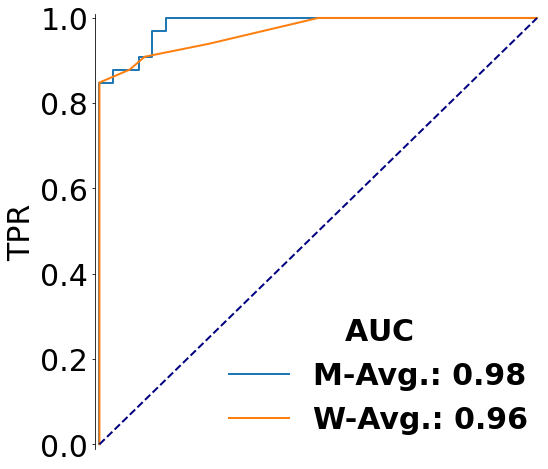

homo HLA-B =1 
 [0. 1.]


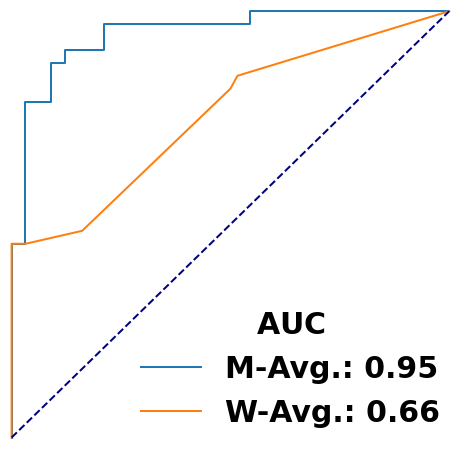

B Cells Memory 
 ['Min' 'Not Min']


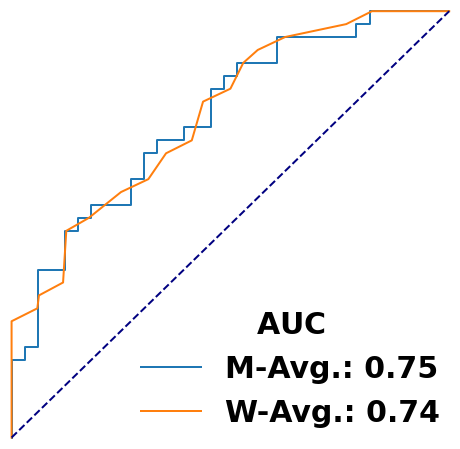

Th17 Cells 
 ['High' 'Low' 'Moderate']


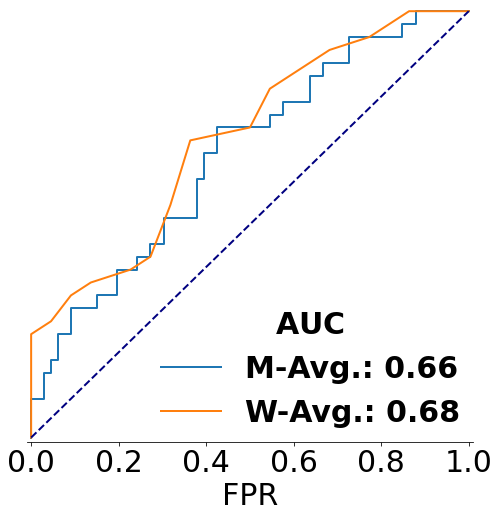

Monocytes 
 ['High' 'Low' 'Moderate']


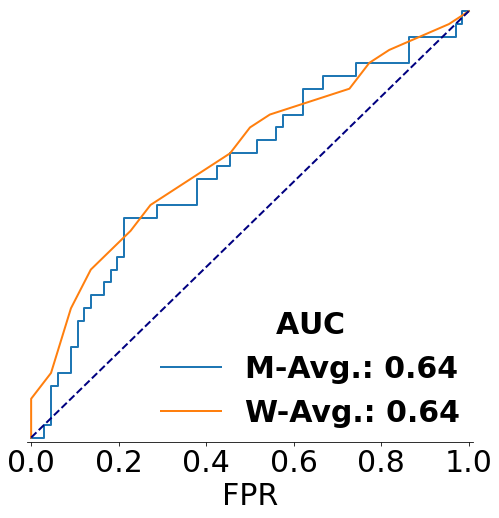

Dendritic Cells Activated 
 ['Min' 'Not Min']


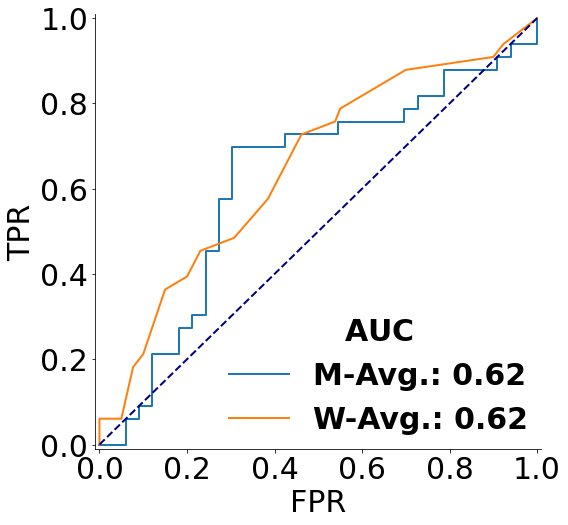

Macrophage Regulation 
 ['High' 'Low' 'Moderate']


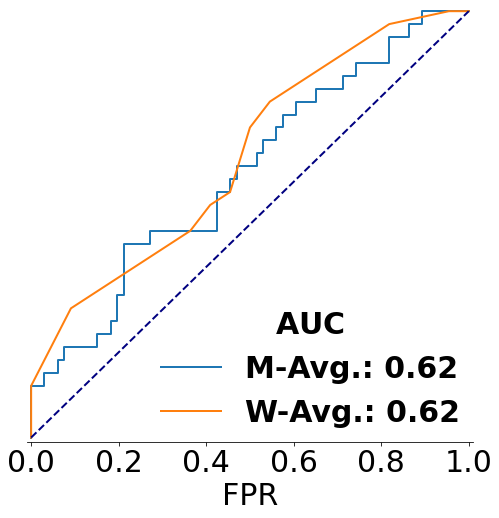

HLA-C1 
 ['HLA-C*03:03' 'HLA-C*04:01' 'HLA-C*05:01' 'HLA-C*06:02' 'HLA-C*07:01'
 'HLA-C*07:02' 'HLA-C*12:03' 'HLA-C*16:01' 'HLA-C*17:01']


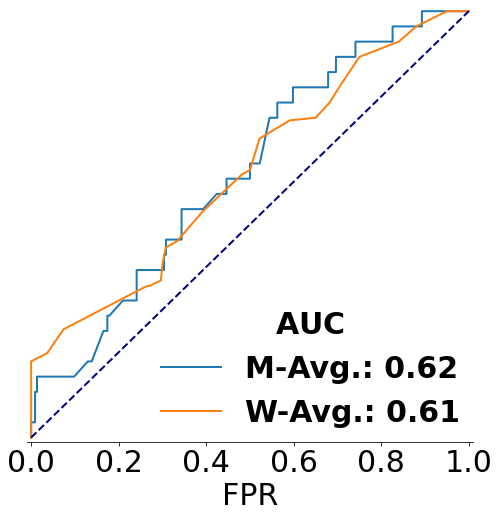

STAD
Homozygous in all three loci = 1 
 [0. 1.]


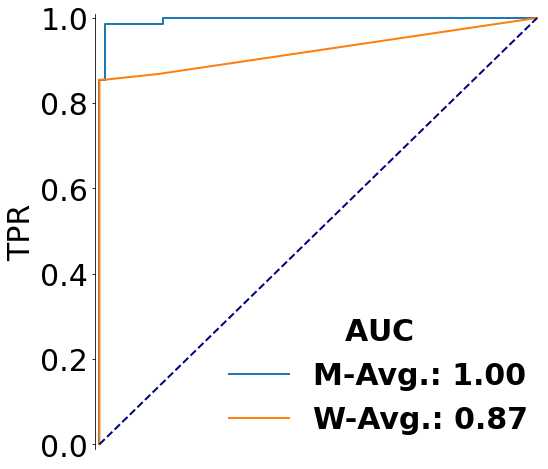

homo HLA-B =1 
 [0. 1.]


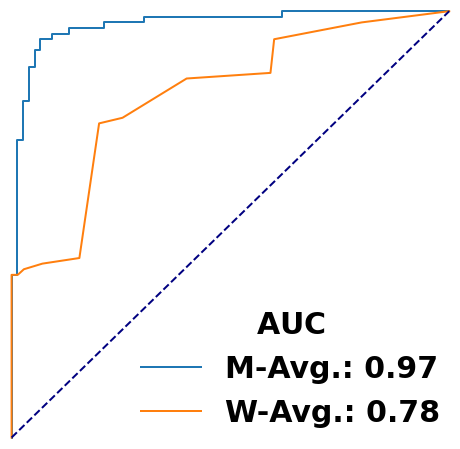

Eosinophils 
 ['Min' 'Not Min']


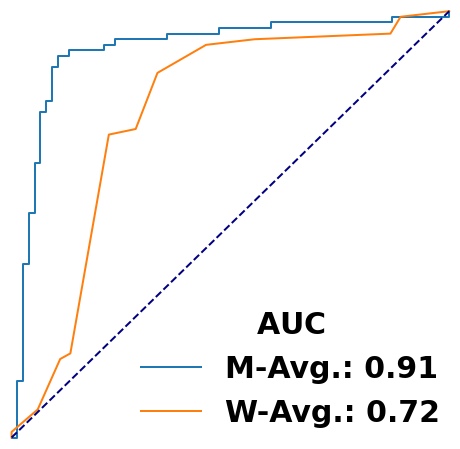

homo HLA-C =1 
 [0. 1.]


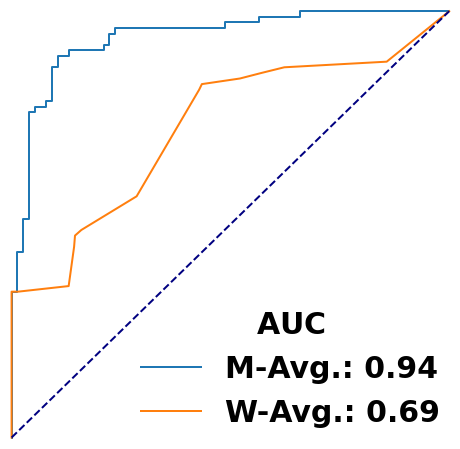

homo HLA-A =1 
 [0. 1.]


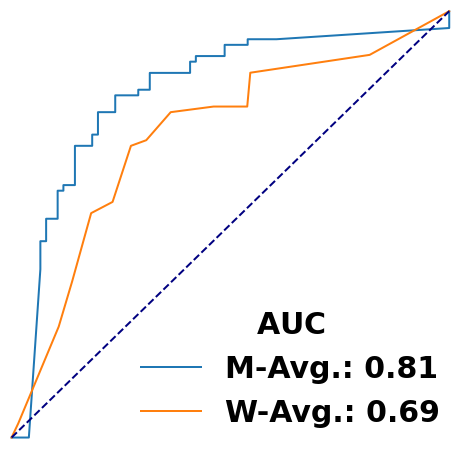

T Cells Regulatory Tregs 
 ['High' 'Low' 'Moderate']


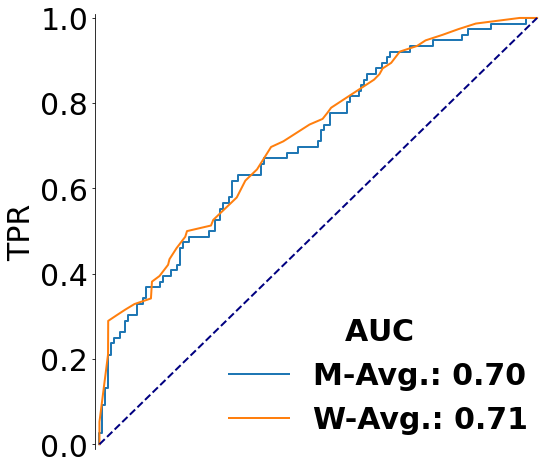

BCR Evenness 
 ['High' 'Low' 'Moderate']


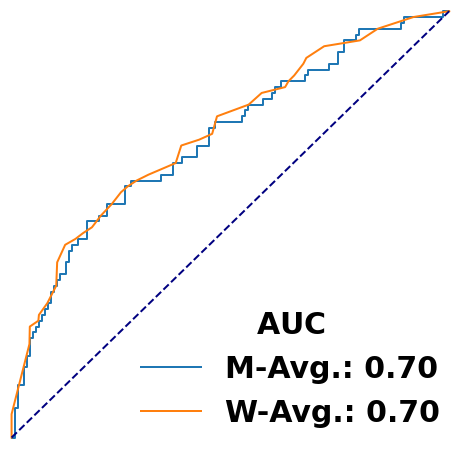

Mast Cells Resting 
 ['Min' 'Not Min']


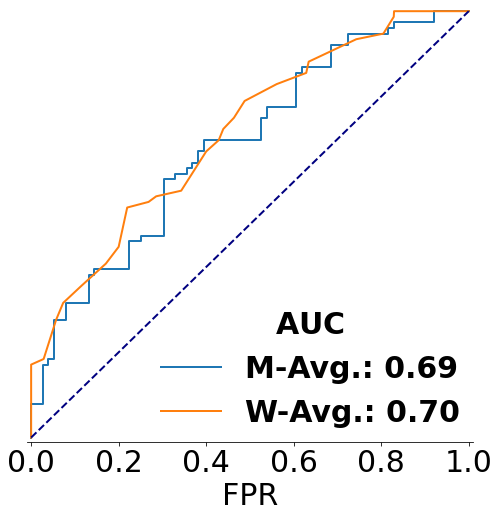

T Cells CD8 
 ['High' 'Low' 'Moderate']


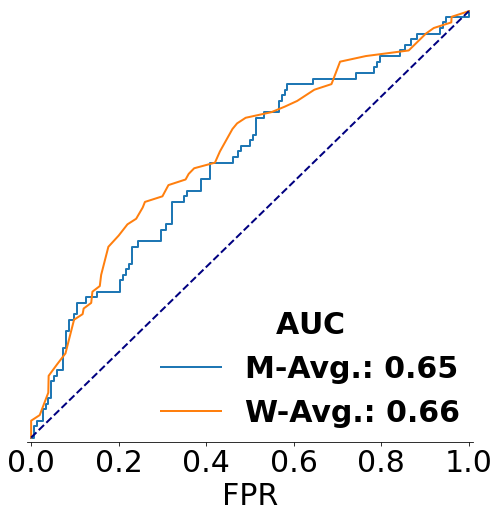

T Cells CD4 Memory Activated 
 ['Min' 'Not Min']


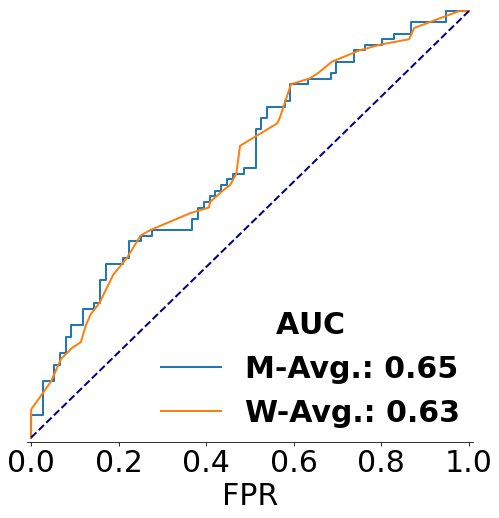

Macrophages M0 
 ['High' 'Low' 'Moderate']


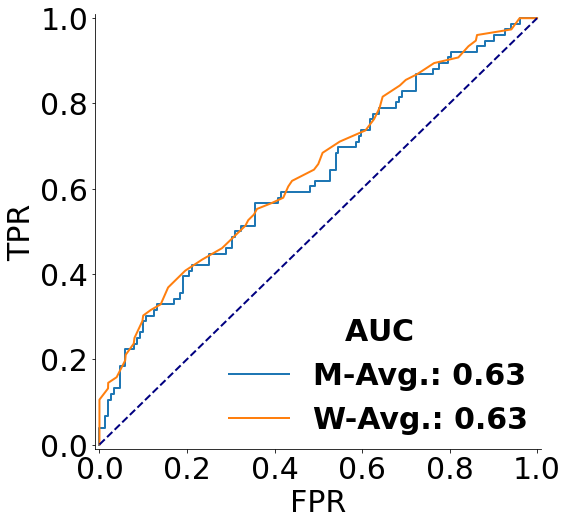

Mast Cells Activated 
 ['High' 'Low']


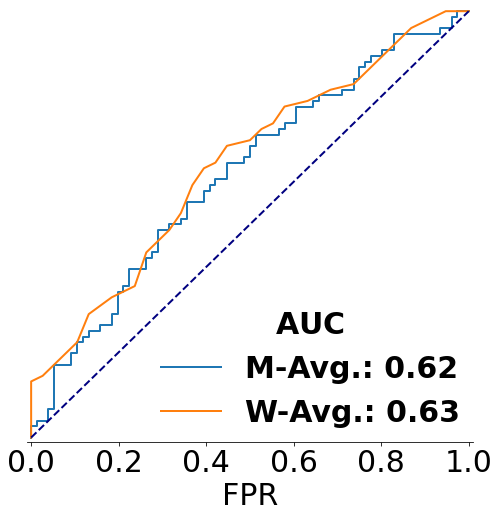

In [10]:
for CANCER in ['COAD', 'STAD']:
    print('=================================')
    print(CANCER)
    print('=================================')
    roc_curve_all(disease=CANCER, plot_axis='default')

---

### For website "x1y1"

In [7]:
def roc_curve_all(disease, fig_save_folder='./figures/ROC', variables=None, fontsize=30, bbox_to_anchor=(1.03, -0.03), 
                  plot_axis='x1y1', plot_num_per_row=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import os

    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    lrp_result_save_folder = './results/LRP/%s' % disease
    with open(os.path.join(lrp_result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
    
    if variables is None:
        plot_var = lrp_result_dict['y_col_names']
    else:
        plot_var = variables
        
    n_row = np.ceil(len(plot_var)/plot_num_per_row)
    n_full_col = len(plot_var)%plot_num_per_row
       
    for idx, cov in enumerate(list(plot_var)):
        y_test_cov = prediction_result_dict['y_train_test'][cov][1]

        y_test = label_binarize(y_test_cov.values, classes=prediction_result_dict['classes'][cov])
        if y_test.shape[1]==1:
            y_test = np.hstack((1-y_test, y_test))
        y_score = prediction_result_dict['pred_proba'][cov].cpu().numpy()
        classes = prediction_result_dict['classes'][cov]
        print(cov, '\n', classes)
        
        # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        tt = dict()
        
        for i, c in enumerate(classes):
            if sum(y_test[:, i]) == 0:
                continue
            fpr[c], tpr[c], tt[c] = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[c] = auc(fpr[c], tpr[c])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

        # Then interpolate all ROC curves at this points with prevelence as weights
        mean_tpr = np.zeros_like(all_fpr)
        for i in classes:
            mean_tpr += np.sum(y_test_cov == i) * np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute weighted average AUC
        mean_tpr /= len(y_test_cov)
        
        mean_tpr = np.insert(mean_tpr, [0, len(mean_tpr)], [0., 1.])
        all_fpr = np.insert(all_fpr, [0, len(all_fpr)], [0., 1.])

        fpr["weighted"] = all_fpr
        tpr["weighted"] = mean_tpr
        roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])
        
        stored_auc = prediction_result_dict['auc'][cov]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        lw = 2
        
#         import matplotlib
#         cmap = matplotlib.cm.get_cmap('Set1')

        plt.plot(
        fpr['micro'],
        tpr['micro'],
        lw=lw,
#         color=cmap(0),
        label=f"M-Avg.: {stored_auc[0]:0.2f}"
        )
        
        plt.plot(
        fpr['weighted'],
        tpr['weighted'],
        lw=lw,
#         color=cmap(1),
        label=f"W-Avg.: {stored_auc[1]:0.2f}"
        )
        legend_properties = {'weight':'bold', 'size':fontsize}
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        
        if plot_axis == 'default':
            if idx%plot_num_per_row == 0 and  idx//plot_num_per_row == n_row-1: axis = 'x1y1'
            elif idx%plot_num_per_row == 0: axis = 'x0y1'
            elif idx//plot_num_per_row == n_row-1: axis = 'x1y0'
            elif idx%plot_num_per_row > n_full_col-1  and idx//plot_num_per_row == n_row-2: axis = 'x1y0'
            else: axis = 'x0y0'
        elif plot_axis in ['x1y1', 'x0y1', 'x1y0', 'x0y0']:
            axis = plot_axis
        else:
            raise ValueError("Please choose a value for argument 'axis' among "\
                             "{'default', 'x1y1', 'x0y1', 'x1y0', 'x0y0'}!")
        
        if axis == 'x1y1':
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x0y1':
            ax.spines['bottom'].set_visible(False)
            
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x1y0':
            ax.spines['left'].set_visible(False)
            
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("")
            plt.yticks([])
        elif axis == 'x0y0':
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("")
            plt.yticks([])
        
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        legend = plt.legend(loc='lower right', bbox_to_anchor=bbox_to_anchor, title=r'$\bf{AUC}$', 
                            frameon=False, prop=legend_properties)
        title = legend.get_title()
        title.set_fontsize(fontsize)
        plt.show()
        
        os.makedirs(f"{fig_save_folder}/{disease}", exist_ok=True)
        fig.savefig(f"{fig_save_folder}/{disease}/{cov}_{axis}.png", bbox_inches='tight')

homo HLA-B =1 
 [0. 1.]


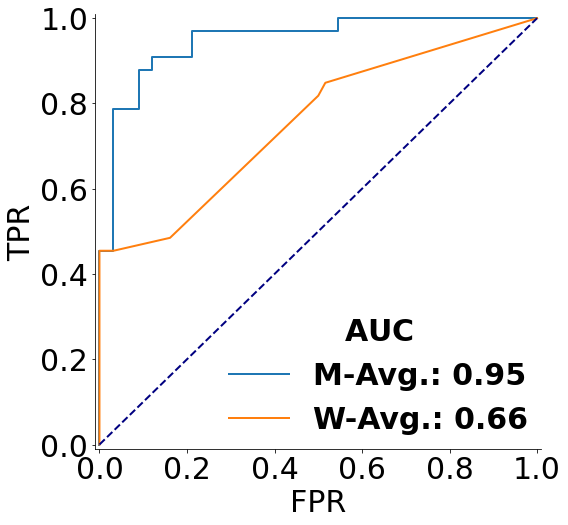

HLA-C1 
 ['HLA-C*03:03' 'HLA-C*04:01' 'HLA-C*05:01' 'HLA-C*06:02' 'HLA-C*07:01'
 'HLA-C*07:02' 'HLA-C*12:03' 'HLA-C*16:01' 'HLA-C*17:01']


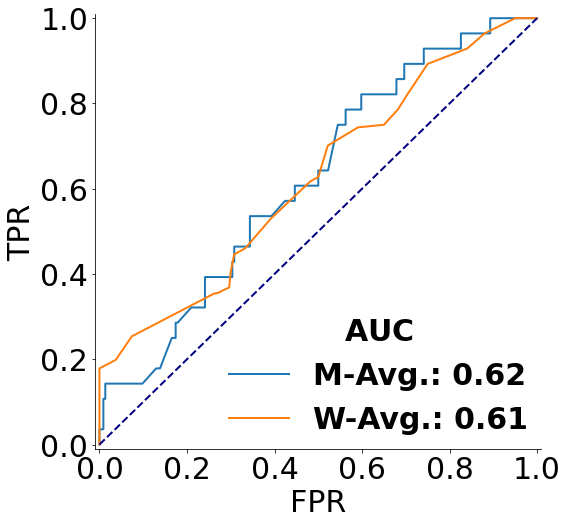

homo HLA-C =1 
 [0. 1.]


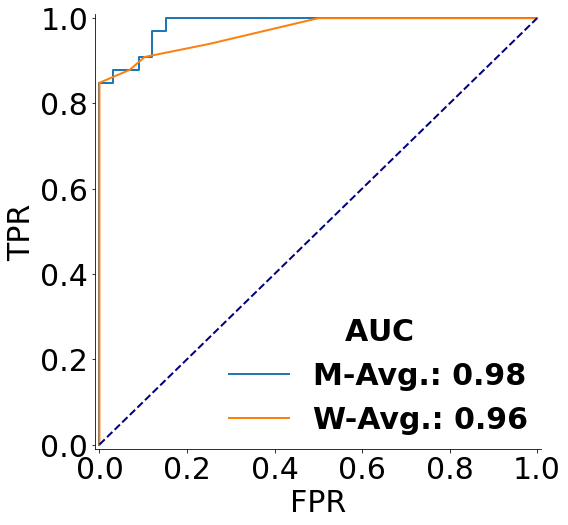

Macrophage Regulation 
 ['High' 'Low' 'Moderate']


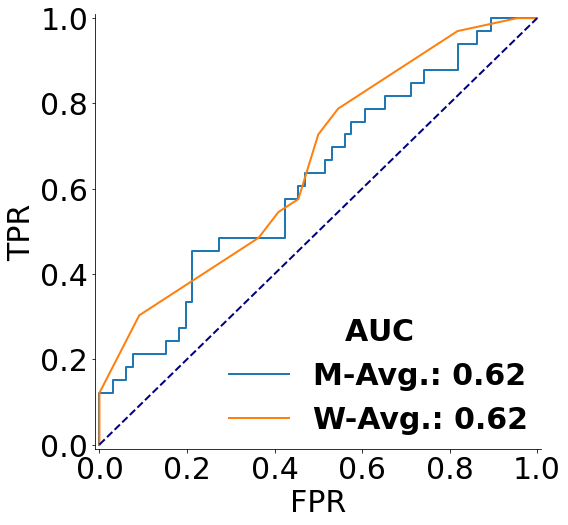

Th17 Cells 
 ['High' 'Low' 'Moderate']


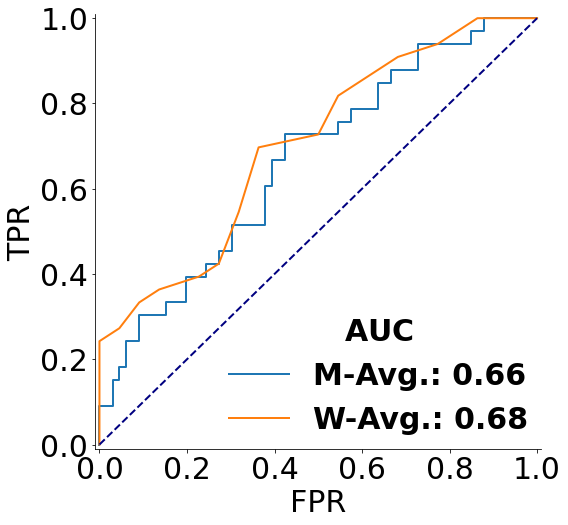

B Cells Memory 
 ['Min' 'Not Min']


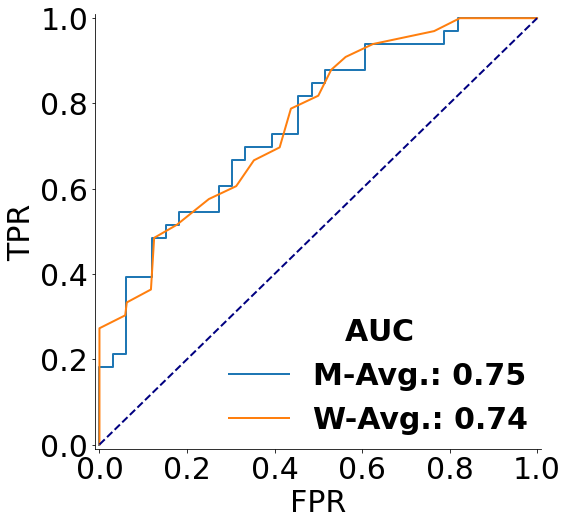

Dendritic Cells Activated 
 ['Min' 'Not Min']


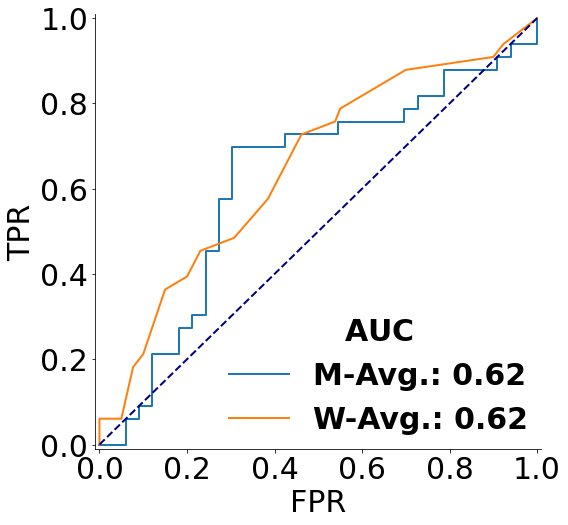

Monocytes 
 ['High' 'Low' 'Moderate']


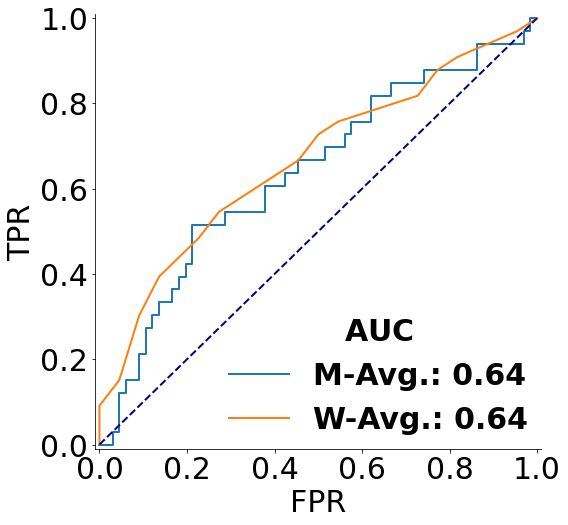

homo HLA-A =1 
 [0. 1.]


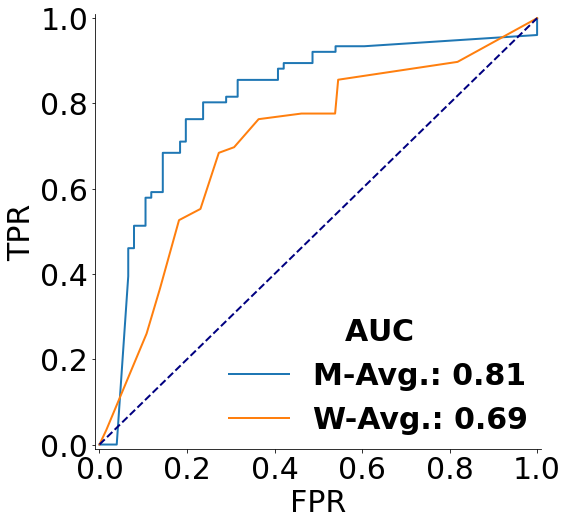

homo HLA-B =1 
 [0. 1.]


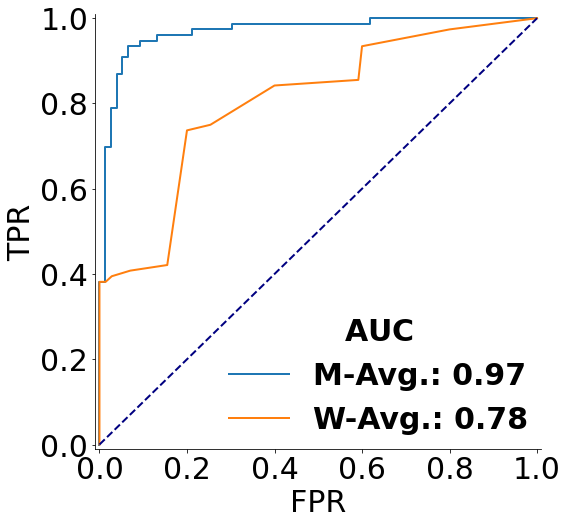

homo HLA-C =1 
 [0. 1.]


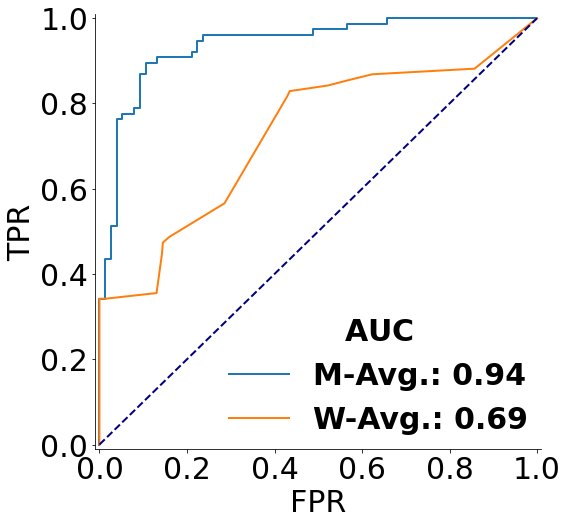

Homozygous in all three loci = 1 
 [0. 1.]


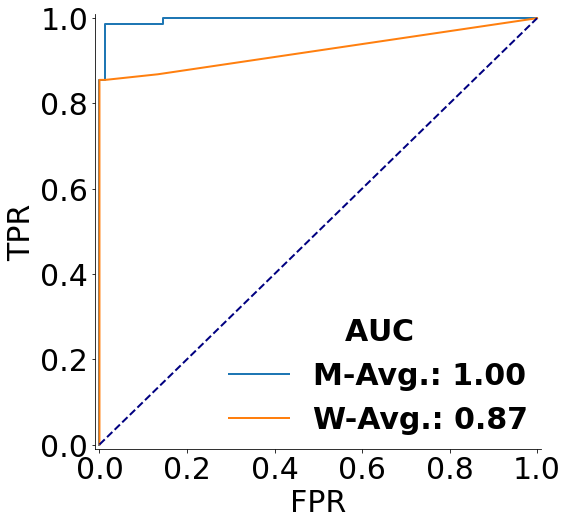

BCR Evenness 
 ['High' 'Low' 'Moderate']


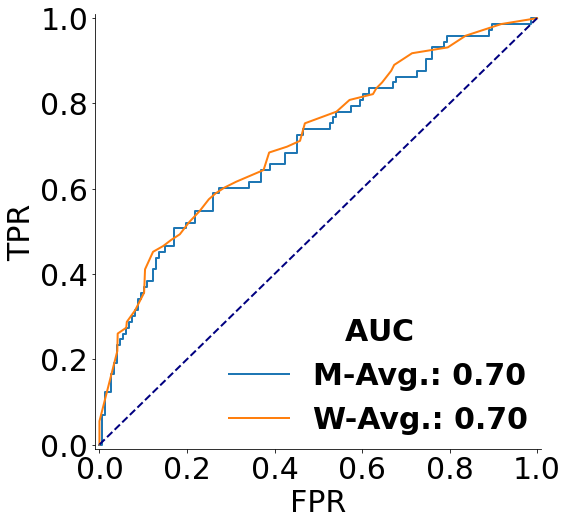

Eosinophils 
 ['Min' 'Not Min']


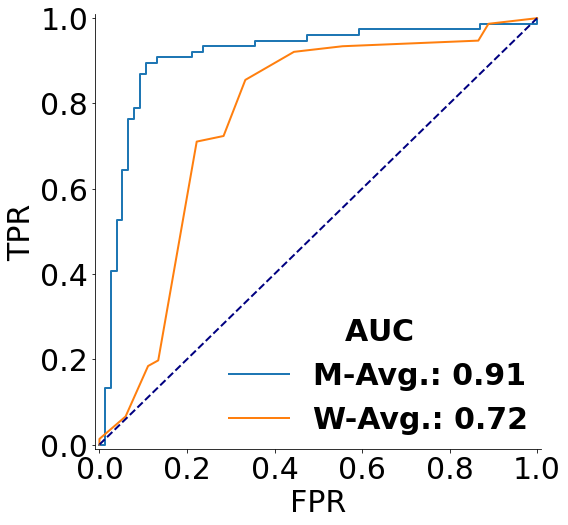

Macrophages M0 
 ['High' 'Low' 'Moderate']


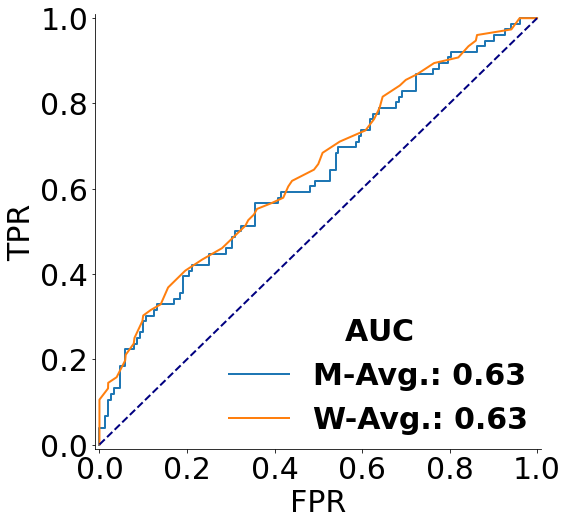

Mast Cells Activated 
 ['High' 'Low']


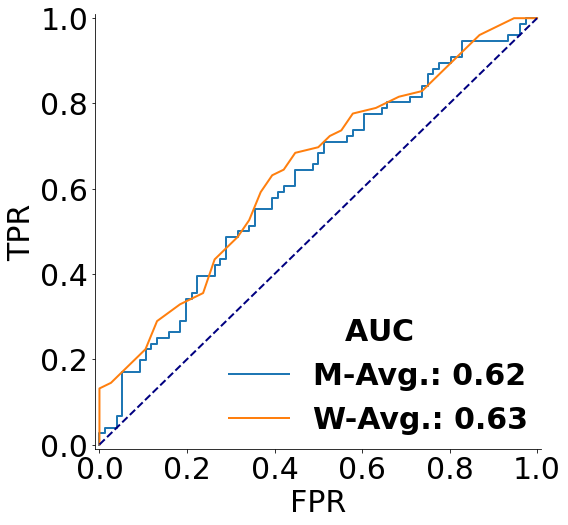

Mast Cells Resting 
 ['Min' 'Not Min']


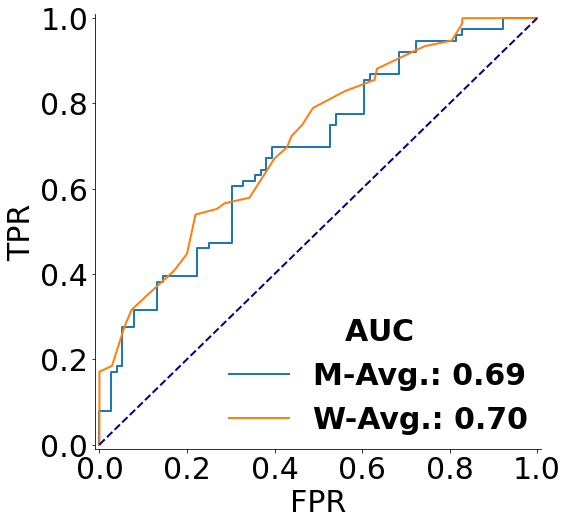

T Cells CD4 Memory Activated 
 ['Min' 'Not Min']


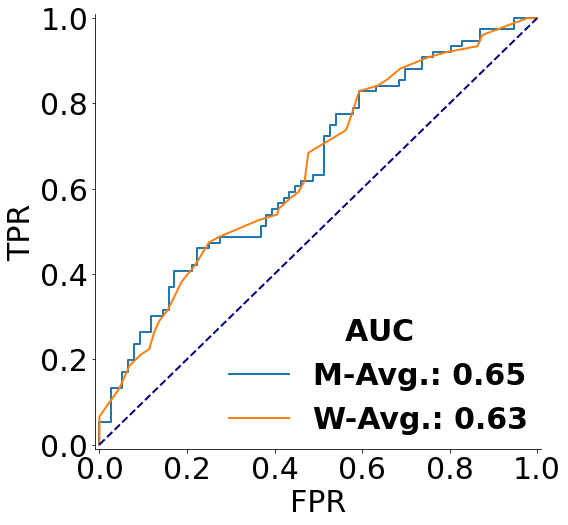

T Cells CD8 
 ['High' 'Low' 'Moderate']


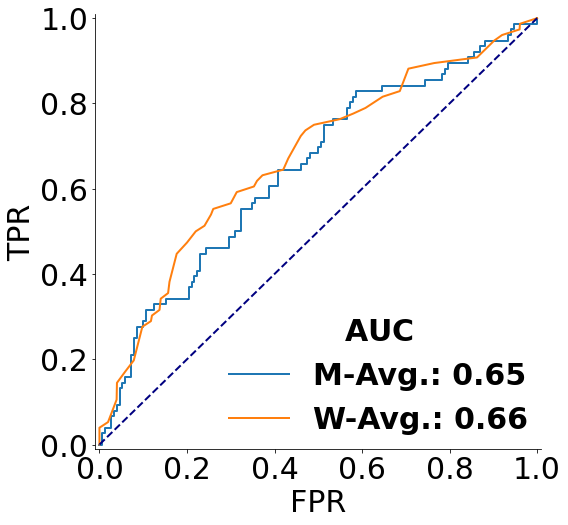

T Cells Regulatory Tregs 
 ['High' 'Low' 'Moderate']


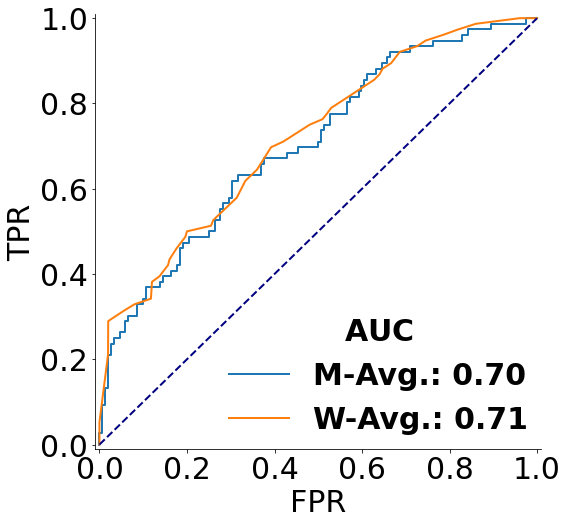

In [8]:
roc_curve_all(disease='COAD', fig_save_folder='./figures/web_ROC', plot_axis='x1y1')
roc_curve_all(disease='STAD', fig_save_folder='./figures/web_ROC', plot_axis='x1y1')

## Heatmap

In [34]:
def sort_influence(disease, save_folder='./', decreasing=True, covariate_list=None):
    with open(os.path.join(save_folder, f'results/LRP/{disease}/lrp_result_dict.pkl'), "rb") as f:
        lrp_result_dict = pickle.load(f)
    influence = lrp_result_dict['influence_by_microbe_all']
    row_names = lrp_result_dict['y_col_names'] if covariate_list is None else covariate_list
    column_names = pd.read_pickle(os.path.join(save_folder, 
                                               f'data/processed data/{disease}_microbiome_clean.pkl')).columns
    ### Sorted by col sum
    ascending_sort_idx_col = np.argsort(np.sum(influence, axis=0))
    sort_idx_col = ascending_sort_idx_col[::-1] if decreasing else ascending_sort_idx_col
    ### Sorted row by AUC scores
    sorted_auc_df = sorted_auc(disease, print_disease_name=False)
    sort_idx_row = np.array([np.where(rn == row_names)[0][0] for rn in sorted_auc_df['Covariate']])
    sorted_influence_df = pd.DataFrame(influence[sort_idx_row,:][:, sort_idx_col], 
                                columns = column_names[sort_idx_col], 
                                index = sorted_auc_df['Covariate'].values)
    return sorted_influence_df

In [35]:
def heatmap_influence(disease, influence_df, top_col_pct=0.05, plot=True, covariate_subset=None,
                      cmap="Blues", cbar=True, cmax=None, taxa_names=True, feature_names=True,
                      fontsize=16, font_scale=2.5, linewidths=0., horizontal=True, 
                      save=False, fig_save_folder='./figures'):
    
    import seaborn as sns
    taxa_name = list(influence_df.columns)
    genus_name = [tn.split('__')[-1] for tn in taxa_name]
    nona_idx = np.where(np.array(genus_name) != '')[0]
    genus_name_nona = np.array(genus_name)[nona_idx]
    
    influence_df_genus_lvl = influence_df.iloc[:, nona_idx]
    influence_df_genus_lvl.columns = list(genus_name_nona)
    
    n_col_selected = np.round(influence_df_genus_lvl.shape[1] * top_col_pct).astype(int)
    
    if covariate_subset is None:
        row_subset = influence_df_genus_lvl.index
    else:
        row_subset = covariate_subset
    
    influence_df_genus_lvl_marker = influence_df_genus_lvl.loc[row_subset, influence_df_genus_lvl.columns[:n_col_selected]]
    if top_col_pct==1.: 
        influence_df_genus_lvl_marker.to_csv(f'./results/LRP/{disease}/sorted_influence_df.csv')
    else:
        influence_df_genus_lvl_marker.to_csv(f'./results/LRP/{disease}/sorted_influence_df_pct{str(int(top_col_pct*100))}.csv')

    if plot:
        if horizontal:
            figheight = len(row_subset)*2-2
            figwidth = n_col_selected*2
            fig, ax = plt.subplots(figsize=(figwidth, figheight))
            print(influence_df_genus_lvl_marker.T.shape)
            hm = sns.heatmap(influence_df_genus_lvl_marker, linewidths=linewidths, cbar=cbar, cbar_kws={"pad":0.01}, 
                            cmap=cmap, vmin=0, vmax=cmax)
            if taxa_names: hm.set_xticklabels(hm.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor', fontsize=fontsize)
            else: hm.set_xticklabels([])
            if feature_names: hm.set_yticklabels(hm.get_yticklabels(), fontsize=fontsize, rotation=0, ha='right')
            else: hm.set_yticklabels([])
        else:
            figwidth = len(row_subset)*2-2
            figheight = n_col_selected*2
            fig, ax = plt.subplots(figsize=(figwidth, figheight))
            # Use transposed DF
            print(influence_df_genus_lvl_marker.T.shape)
            hm = sns.heatmap(influence_df_genus_lvl_marker.T, linewidths=linewidths, cbar=cbar, cbar_kws={"pad":0.01, "orientation":"horizontal"}, 
                            cmap=cmap, vmin=0, vmax=cmax)
            if taxa_names: hm.set_yticklabels(hm.get_yticklabels(), rotation=30, ha='right', rotation_mode='anchor', fontsize=fontsize+10)
            else: hm.set_yticklabels([])
            if feature_names: hm.set_xticklabels(hm.get_xticklabels(), fontsize=fontsize-5, rotation=30, ha='left')
            else: hm.set_xticklabels([])
        # want a more natural, table-like display
        ax.tick_params(top = False, labelbottom=False, labeltop=True)
        sns.set(font_scale=font_scale)
        if cmax is None: cmax = np.max(np.array(influence_df).reshape(-1))
        hm.figure.axes[-1].yaxis.label.set_size(40)
        # use matplotlib.colorbar.Colorbar object
        if cbar==True:
            cbar = hm.collections[0].colorbar
            cbar.ax.tick_params(labelsize=40)
        plt.show()
    
        if save:
            os.makedirs(f"{fig_save_folder}", exist_ok=True)
            fig.savefig(f"{fig_save_folder}/biomarker_heatmap_{disease}.pdf", bbox_inches='tight')
            fig.savefig(f"{fig_save_folder}/biomarker_heatmap_{disease}.png", bbox_inches='tight')
    
    return influence_df_genus_lvl_marker

In [75]:
COAD_sorted_influence_df = sort_influence('COAD')
np.max(np.array(COAD_sorted_influence_df).reshape(-1))

163.99838

(62, 8)


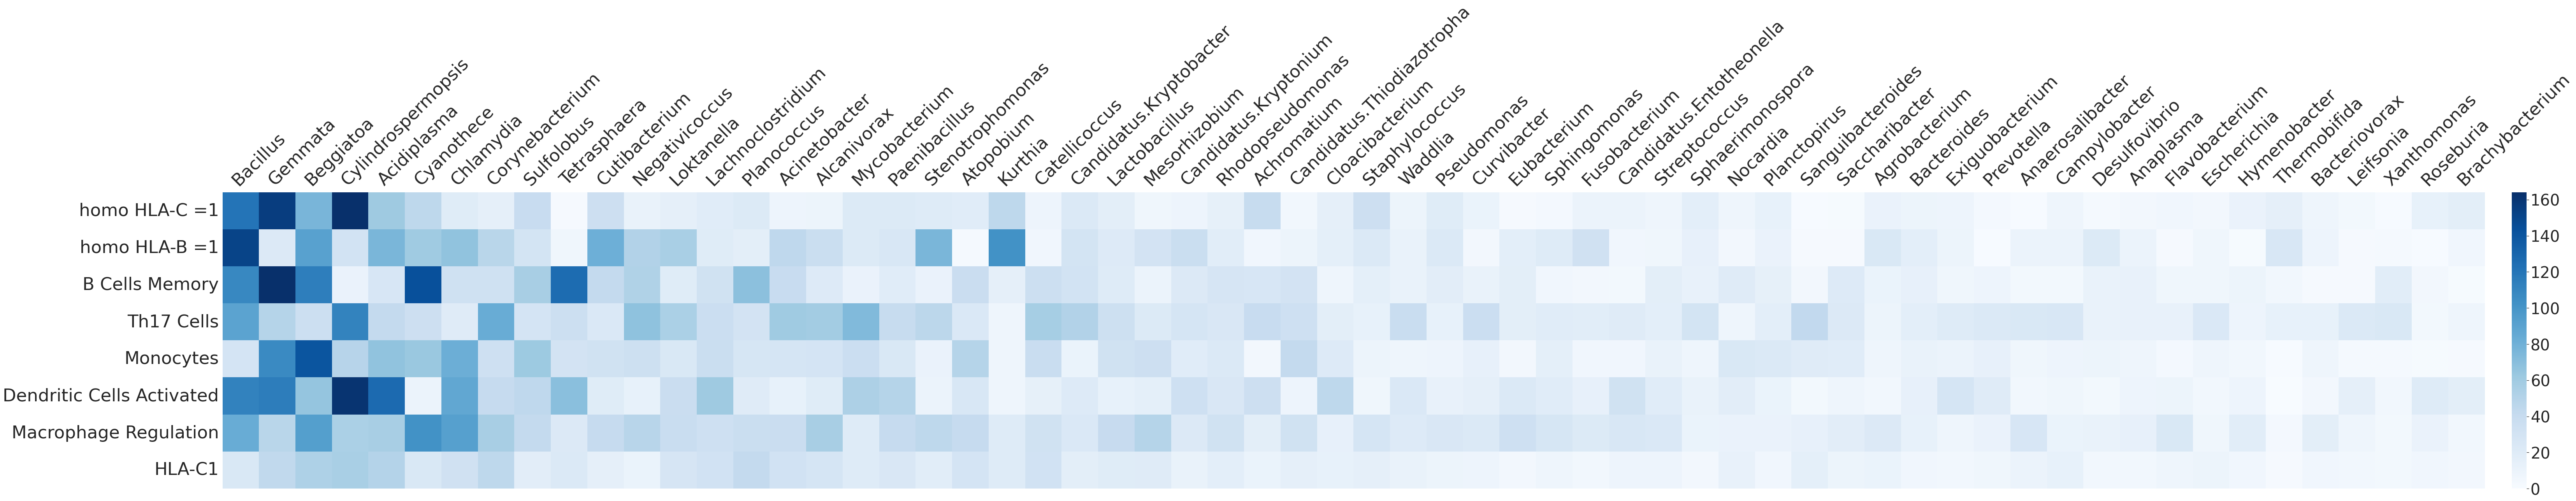

In [40]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap="Blues", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=False, taxa_names=True, fontsize=45,
                                                    horizontal=True)

(62, 8)


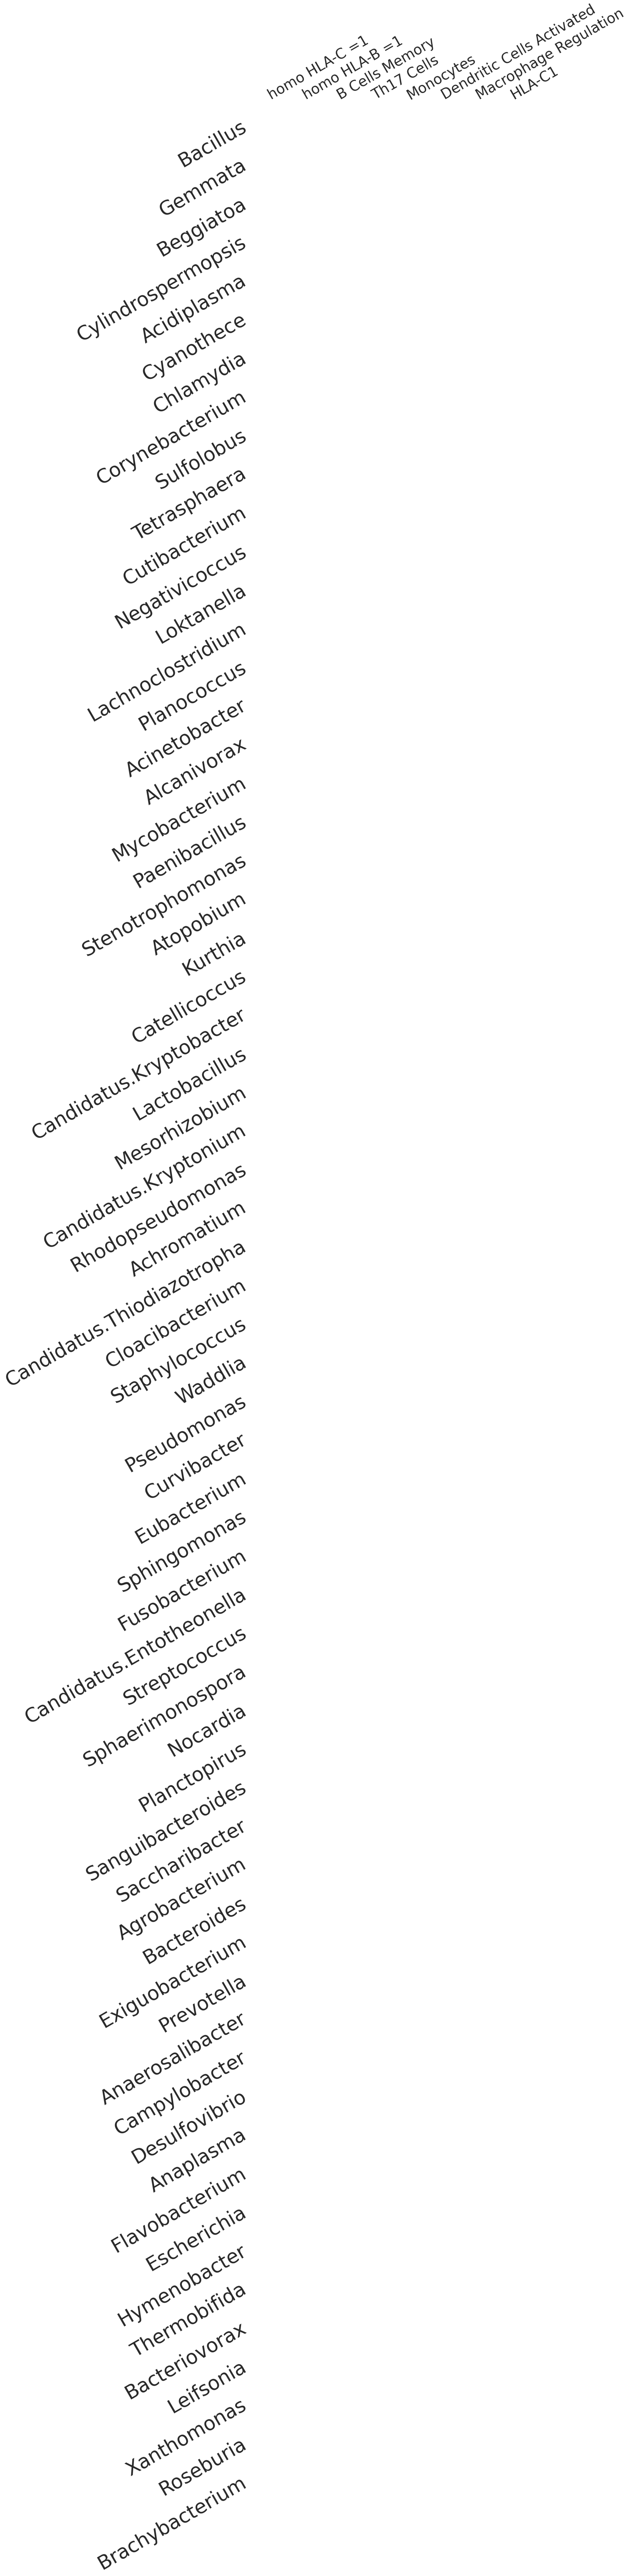

In [76]:
from matplotlib.colors import ListedColormap
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap=ListedColormap(['white']), #"Blues", "YlOrBr", "Reds"
                                                    cbar=False, top_col_pct=0.05, save=True, taxa_names=True, fontsize=45,
                                                    horizontal=False, feature_names=True)

(62, 8)


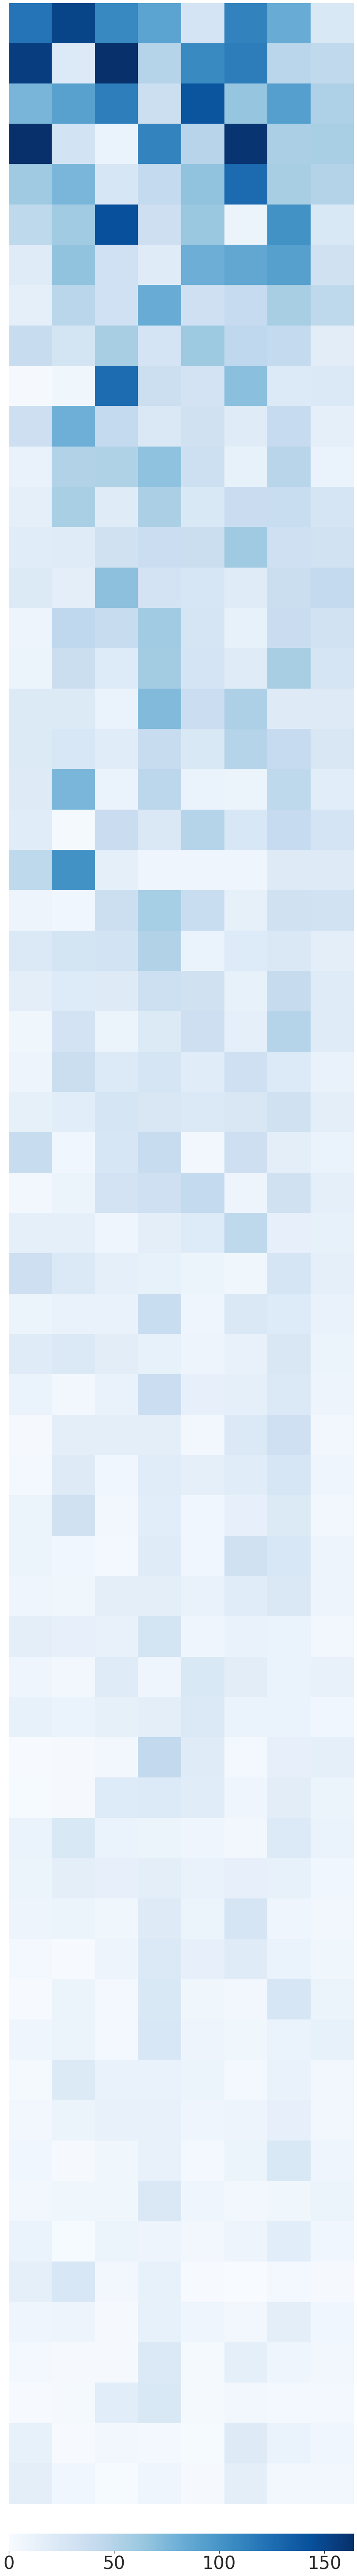

In [77]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap="Blues", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=True, taxa_names=False, fontsize=45,
                                                    horizontal=False, feature_names=False)

In [58]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, top_col_pct=0.01, plot=False)

In [59]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, top_col_pct=1., plot=False)

In [60]:
COAD_sorted_influence_df_subset

Bacillus     Gemmata   Beggiatoa  \
homo HLA-C =1              120.527435  155.566788   76.843872   
homo HLA-B =1              151.701569   22.696892   91.055412   
B Cells Memory             108.721535  163.952942  114.793846   
Th17 Cells                  89.936394   49.408352   35.964138   
Monocytes                   29.019472  107.243324  140.627502   
Dendritic Cells Activated  112.317932  115.457542   65.203117   
Macrophage Regulation       83.534073   47.581039   93.093605   
HLA-C1                      24.828543   44.050285   53.262848   

                           Cylindrospermopsis  Acidiplasma  Cyanothece  \
homo HLA-C =1                      163.998383    61.100048   45.068913   
homo HLA-B =1                       31.109682    76.169106   60.411564   
B Cells Memory                      11.444288    26.486244  143.754669   
Th17 Cells                         111.963295    41.977715   35.641937   
Monocytes                           49.290161    66.655388   63.306648   
Dendritic Cells Activated          161.109848   127.141861    9.919168   
Macrophage Regulation               55.066235    56.523998  102.159218   
HLA-C1                              56.033882    50.408154   24.756004   

                           Chlamydia  Corynebacterium  Sulfolobus  \
homo HLA-C =1              19.804718        15.368917   39.122654   
homo HLA-B =1              66.993851        47.873749   29.879404   
B Cells Memory             33.736401        33.943192   56.415768   
Th17 Cells                 20.346323        83.490242   29.255875   
Monocytes                  81.606926        34.496349   61.838081   
Dendritic Cells Activated  86.714745        41.170341   44.681431   
Macrophage Regulation      92.652382        56.652725   42.237820   
HLA-C1                     33.039684        45.325134   17.314663   

                           Tetrasphaera  ...  Cosenzaea  \
homo HLA-C =1                  2.155154  ...   0.003088   
homo HLA-B =1                  6.825995  ...   0.003023   
B Cells Memory               125.773949  ...   0.040040   
Th17 Cells                    35.977299  ...   0.062498   
Monocytes                     30.729544  ...   0.050083   
Dendritic Cells Activated     69.766968  ...   0.077194   
Macrophage Regulation         22.855665  ...   0.063867   
HLA-C1                        23.654200  ...   0.001960   

                           Candidatus.Altiarchaeum  Thermovibrio  Pelistega  \
homo HLA-C =1                             0.003083      0.006804   0.003331   
homo HLA-B =1                             0.002603      0.003605   0.003576   
B Cells Memory                            0.061200      0.047294   0.044168   
Th17 Cells                                0.063353      0.077308   0.076473   
Monocytes                                 0.046977      0.038318   0.041676   
Dendritic Cells Activated                 0.046905      0.052829   0.048984   
Macrophage Regulation                     0.073337      0.071784   0.079309   
HLA-C1                                    0.001892      0.000689   0.001034   

                           Candidatus.Paracaedibacter  Motiliproteus  \
homo HLA-C =1                                0.006825       0.007396   
homo HLA-B =1                                0.002281       0.004780   
B Cells Memory                               0.031903       0.039462   
Th17 Cells                                   0.068803       0.076474   
Monocytes                                    0.037646       0.039525   
Dendritic Cells Activated                    0.067435       0.047355   
Macrophage Regulation                        0.080917       0.078003   
HLA-C1                                       0.001828       0.001052   

                           Desulfobacca  Brevinema  Kamptonema  Mucinivorans  
homo HLA-C =1                  0.007312   0.002914    0.002060      0.002295  
homo HLA-B =1                  0.003944   0.002144    0.006549      0.002769  
B Cells Memory          

---

In [36]:
STAD_sorted_influence_df = sort_influence('STAD')

(62, 12)


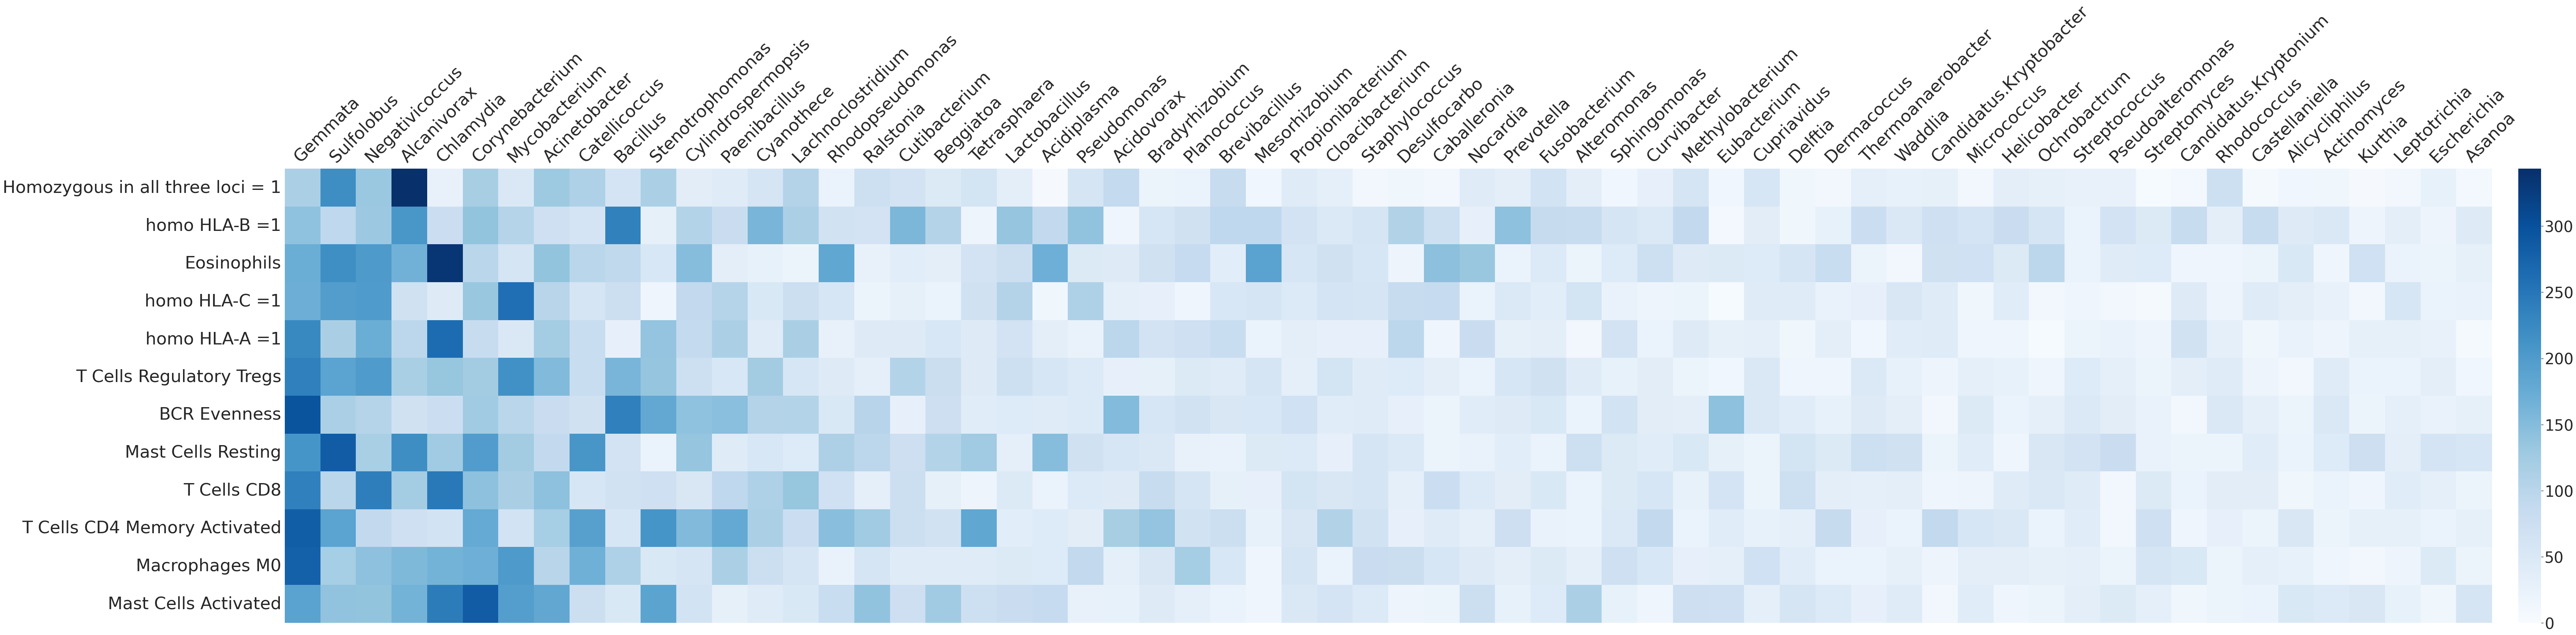

In [62]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap="Blues", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=False, taxa_names=True, fontsize=45,
                                                    horizontal=True)

(62, 12)


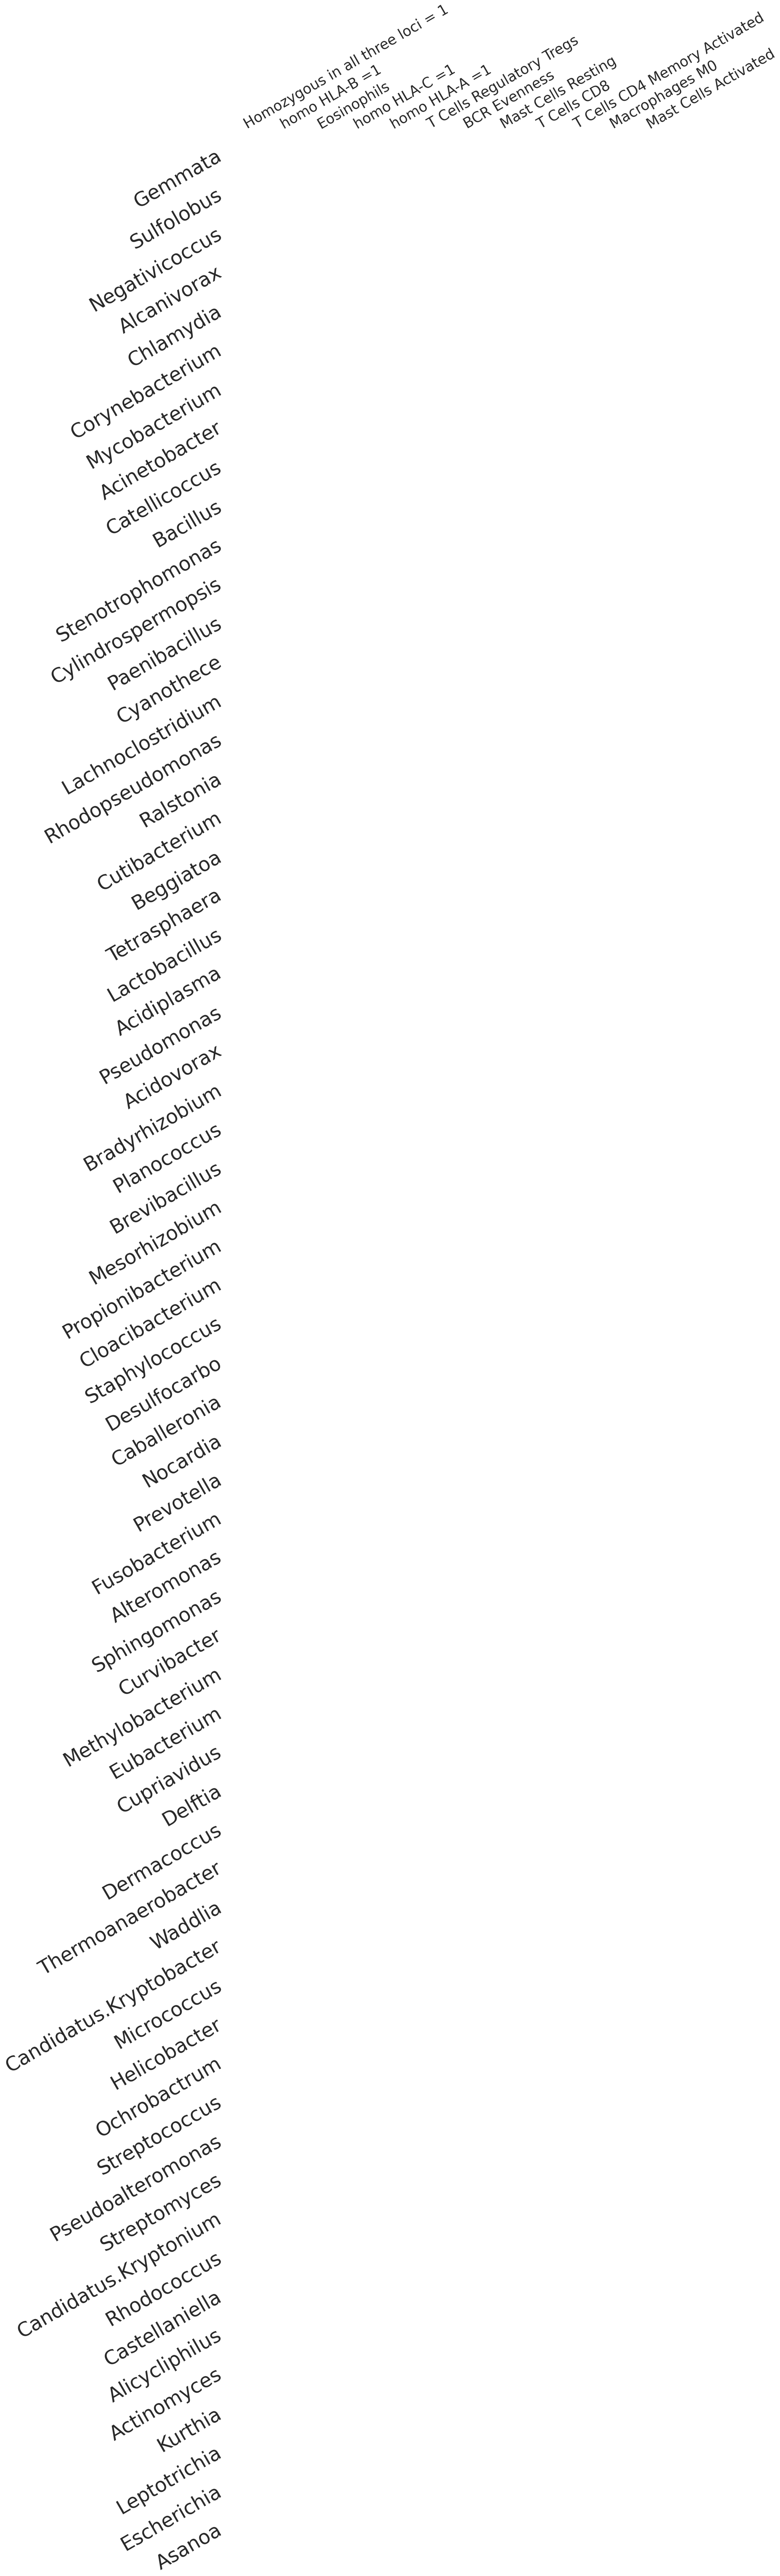

In [39]:
from matplotlib.colors import ListedColormap
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap=ListedColormap(['white']), #"Blues", "YlOrBr", "Reds"
                                                    cbar=False, top_col_pct=0.05, save=True, taxa_names=True, fontsize=45,
                                                    horizontal=False, feature_names=True)

(62, 12)


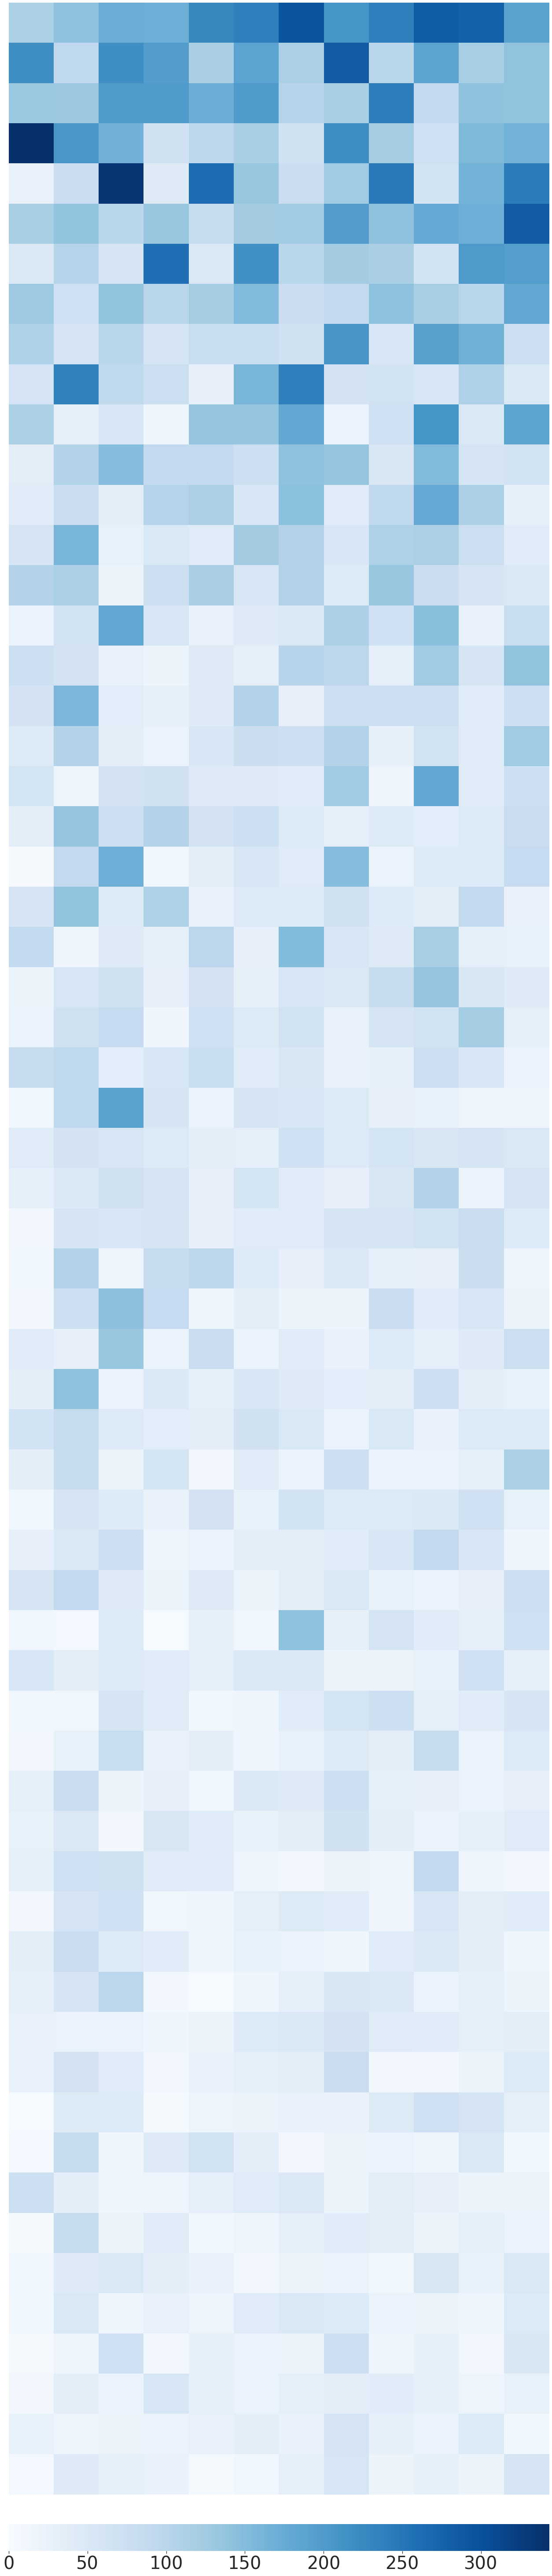

In [38]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap="Blues", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=True, taxa_names=False, fontsize=45,
                                                    horizontal=False, feature_names=False)

In [64]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, top_col_pct=0.01, plot=False)

In [65]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, top_col_pct=1., plot=False)

In [66]:
STAD_sorted_influence_df_subset

Gemmata  Sulfolobus  Negativicoccus  \
Homozygous in all three loci = 1  115.224457  218.656067      131.611237   
homo HLA-B =1                     141.530121   93.868828      130.174210   
Eosinophils                       171.723007  217.982071      202.008896   
homo HLA-C =1                     171.238419  197.834610      200.434280   
homo HLA-A =1                     225.407562  115.396576      172.148575   
T Cells Regulatory Tregs          238.160934  188.039841      201.085342   
BCR Evenness                      295.974152  114.210480      103.817421   
Mast Cells Resting                209.416428  285.390961      117.970703   
T Cells CD8                       238.176361   99.441093      240.906250   
T Cells CD4 Memory Activated      281.834778  187.933060       88.894730   
Macrophages M0                    278.897888  120.056610      142.399750   
Mast Cells Activated              189.123825  140.625305      139.183838   

                                  Alcanivorax   Chlamydia  Corynebacterium  \
Homozygous in all three loci = 1   343.333527   25.992140       118.674225   
homo HLA-B =1                      206.674271   77.427773       138.336182   
Eosinophils                        167.523743  334.584167        99.040283   
homo HLA-C =1                       69.593178   43.707890       132.797379   
homo HLA-A =1                       97.538498  263.154114        82.238197   
T Cells Regulatory Tregs           117.697388  134.153503       123.868080   
BCR Evenness                        67.626175   76.542198       125.589035   
Mast Cells Resting                 219.873032  125.715141       198.998871   
T Cells CD8                        123.101906  247.369873       142.774323   
T Cells CD4 Memory Activated        72.053528   65.715332       177.785507   
Macrophages M0                     154.267578  163.756516       170.044968   
Mast Cells Activated               164.315338  243.005356       284.983398   

                                  Mycobacterium  Acinetobacter  Catellicoccus  \
Homozygous in all three loci = 1      50.414612     129.868240     110.766472   
homo HLA-B =1                        104.596085      71.856255      60.846550   
Eosinophils                           59.013264     138.679840      99.765793   
homo HLA-C =1                        259.403351     101.155952      59.612030   
homo HLA-A =1                         49.781845     122.769707      81.215401   
T Cells Regulatory Tregs             214.602173     153.705215      81.409843   
BCR Evenness                         100.369118      79.479813      67.358658   
Mast Cells Resting                   123.929947      89.274338     207.986130   
T Cells CD8                          116.501045     142.303101      56.020309   
T Cells CD4 Memory Activated          65.159866     120.395348     193.047165   
Macrophages M0                       201.871750     101.816132     168.781204   
Mast Cells Activated                 196.324722     181.507492      75.382210   

                                    Bacillus  ...  Maribius  Rhodomicrobium  \
Homozygous in all three loci = 1   60.989330  ...  0.000023        0.000024   
homo HLA-B =1                     237.375946  ...  0.000150        0.000288   
Eosinophils                        91.228378  ...  0.000045        0.000454   
homo HLA-C =1                      75.784584  ...  0.000139        0.000120   
homo HLA-A =1                      29.402500  ...  0.000086        0.000229   
T Cells Regulatory Tregs          159.963776  ...  0.000879        0.001049   
BCR Evenness                      238.673950  ...  0.001423        0.001176   
Mast Cells Resting                 63.807648  ...  0.000458        0.000464   
T Cells CD8                        65.901962  ...  0.001641        0.001379   
T Cells CD4 Memory Activated       56.022778  ...  0.000408        0.000438   
Macrophages M0                    110.572929  ...  0.001537        0.001398   
Mast Cells Activated           

---
## Save LRP results seperately

In [ ]:
def save_data_n_lrp(disease, save_folder='./', data_save_folder='../data/saved_data'):
    immune_variables_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_immune_variables_disease_microbiome_clean.pkl'.format(disease))
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = immune_variables_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_immune_all = immune_variables_disease_microbiome_clean.iloc[:,2:col_idx]
    data_save_folder1 = os.path.join(data_save_folder, f'{disease}')
    os.makedirs(data_save_folder1, exist_ok=True)
    X_microbiome.to_csv(os.path.join(data_save_folder1, 'X_microbiome.csv'))
    y_immune_all.to_csv(os.path.join(data_save_folder1, 'y_immune_all_cols.csv'))
    
    import pickle
    result_save_folder = os.path.join(save_folder, 'results/LRP/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    with open(os.path.join(result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
    
    R_0_immune_all = lrp_result_dict['R_0_immune_all']
    y_col_names = lrp_result_dict['y_col_names']
    
    for i, col in enumerate(y_col_names):
        classifier, optimizer, hist, X_test, y_test_le, classes, X_nonan, y_nonan_disc = \
            load_model(X=X_microbiome, y=y_immune_all[col],
                       disease=disease, dropout_rate=0.4, weight_decay=0.1)
        R_0_df = pd.DataFrame(R_0_immune_all[i], index=X_nonan.index, columns=X_nonan.columns)
        data_save_folder2 = os.path.join(data_save_folder, f'{disease}/{col}')
        os.makedirs(data_save_folder2, exist_ok=True)
        R_0_df.to_csv(os.path.join(data_save_folder2, 'R_0.csv'))
        X_nonan.to_csv(os.path.join(data_save_folder2, 'X_microbiome_nonan.csv'))
        

In [ ]:
save_data_n_lrp('COAD')
save_data_n_lrp('STAD')